In [1]:
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns
import time
import cv2

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, classification_report, r2_score
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from skimage.feature import greycomatrix, greycoprops
from skimage import data

In [2]:
#flag to load data based on Colab/Local machine
use_colab = True

if use_colab:
  #specify data directory on Google drive mount
  data_dir = 'drive/MyDrive/conic_data'

  # mount your local drive
  from google.colab import drive
  drive.mount('/content/drive')


else:
  data_dir = './data'

Mounted at /content/drive


# Reading the Data

In [3]:
#read images
X = np.load(os.path.join(data_dir, "images.npy"))

In [4]:
X.shape

(4981, 256, 256, 3)

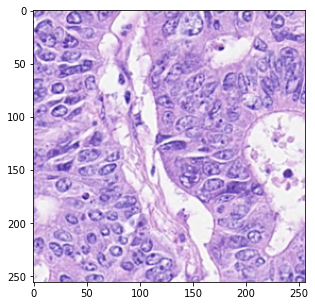

In [5]:
#display one sample image
plt.figure(figsize=(5,5))
plt.imshow(X[0])
plt.show()

In [6]:
#read cell counts
Y = pd.read_csv(os.path.join(data_dir, 'counts.csv'))
Y

neutrophil  epithelial  lymphocyte  plasma  eosinophil  connective
0              0         117           0       0           0           0
1              0          95           1       0           0           8
2              0         172           3       0           0           2
3              0          56           0       0           0          10
4              0         169           7       0           0           0
...          ...         ...         ...     ...         ...         ...
4976           0          22          17       8           2          50
4977           0          78           9       0           0           9
4978           0         106           1       0           0           0
4979           0          80           8       1           0          14
4980           0          99           3       0           0           1

[4981 rows x 6 columns]

In [7]:
F = np.loadtxt(os.path.join(data_dir, 'split.txt'), dtype=np.uint8)           #read fold information
F

array([3, 3, 3, ..., 3, 3, 3], dtype=uint8)

## Number of samples in each fold

In [ ]:
#converting to a DF to view the number of samples in each fold
F_df = pd.DataFrame(F)
F_df.value_counts()

2    1751
1    1622
3    1608
dtype: int64

In [ ]:
#get total number of images in the dataset
X.shape[0]

4981

## Display and analyse some sample images

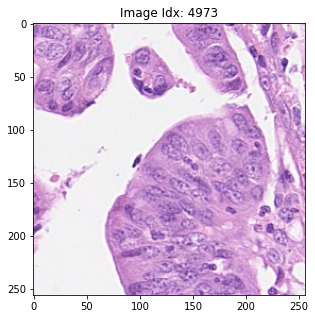

T1: 0 | T2: 66 | T3: 8 | T4: 0 | T5: 0 | T6: 11


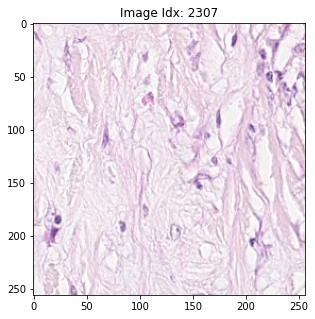

T1: 0 | T2: 0 | T3: 2 | T4: 0 | T5: 0 | T6: 9


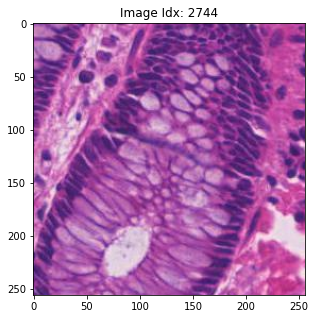

T1: 0 | T2: 87 | T3: 6 | T4: 4 | T5: 0 | T6: 4


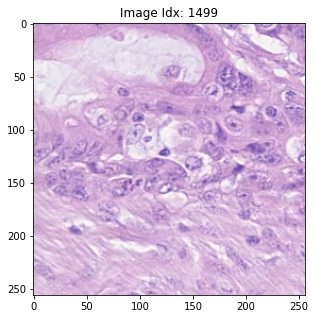

T1: 0 | T2: 37 | T3: 6 | T4: 0 | T5: 0 | T6: 17


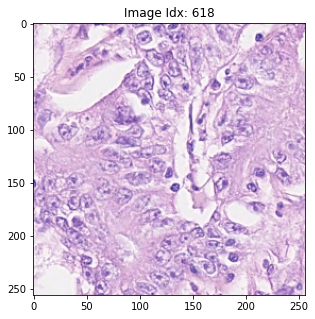

T1: 1 | T2: 73 | T3: 12 | T4: 2 | T5: 0 | T6: 2


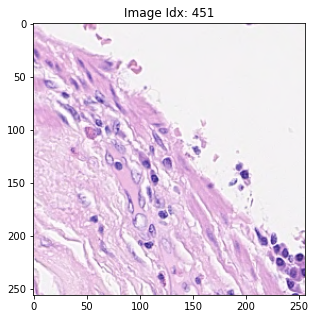

T1: 0 | T2: 0 | T3: 9 | T4: 6 | T5: 0 | T6: 28


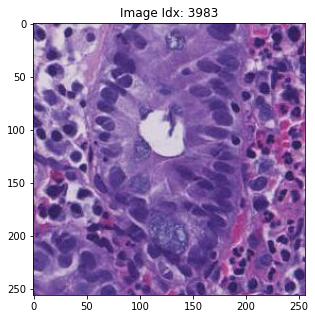

T1: 13 | T2: 55 | T3: 27 | T4: 11 | T5: 2 | T6: 12


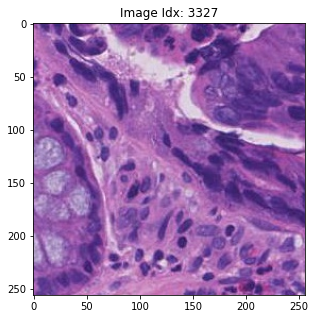

T1: 2 | T2: 45 | T3: 19 | T4: 5 | T5: 0 | T6: 18


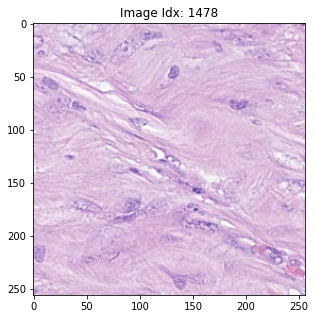

T1: 0 | T2: 0 | T3: 2 | T4: 0 | T5: 0 | T6: 26


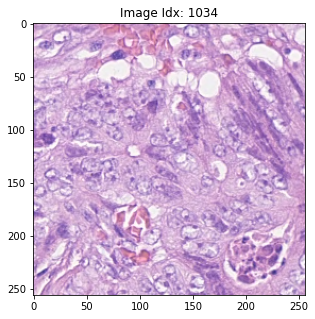

T1: 0 | T2: 56 | T3: 4 | T4: 0 | T5: 0 | T6: 12


In [ ]:
#display 10 random samples from the full dataset
for i in range(10):
    idx = random.randrange(X.shape[0])
    plt.figure(figsize=(5,5))
    plt.imshow(X[idx])
    plt.title(f'Image Idx: {idx}')
    plt.show()
    
    #show cell count below each corresponding image
    counts = Y.iloc[idx]
    print(f'T1: {counts[0]} | T2: {counts[1]} | T3: {counts[2]} | T4: {counts[3]} | T5: {counts[4]} | T6: {counts[5]}')

On first viewing, it is clear that the images do look quite different to the human eye, in terms of colour as well as shapes/structure. Counting the number of occurences of a certain cell type is quite difficult, especially if one is not a domain expert and isn't exactly sure what each of the cell types look like.

On running the above cell a few times to display different random image samples, it looks like **T2**, **T3** and **T6** seem to have a relatively higher count among the 6 cell types. It also appears as though there is a positive correlation between the number of **dark purple** circular structures in the images and the **T3** cell count.

## Cell Count vs Cell Type
#### Plotting the count of each of the cell types for all images in Fold-1, checking for correlation

X-axis of the plots correspond to the different bin ranges and y-axis the frequency.

In [ ]:
#load Fold-1 data
fold_1_idx = (F==1)
fold_1_imgs = X[fold_1_idx]
fold_1_labels = np.array(Y[fold_1_idx])

print('Fold_1_imgs shape: ', fold_1_imgs.shape)
print('Fold_1_labels shape: ', fold_1_labels.shape)

Fold_1_imgs shape:  (1622, 256, 256, 3)
Fold_1_labels shape:  (1622, 6)


	##################################### T1 #####################################


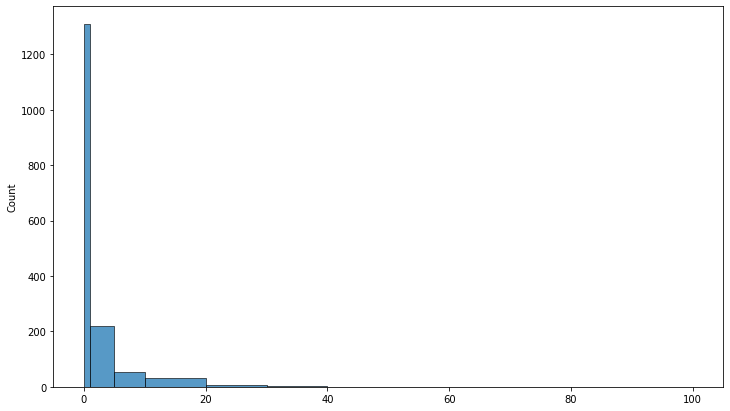

	##################################### T2 #####################################


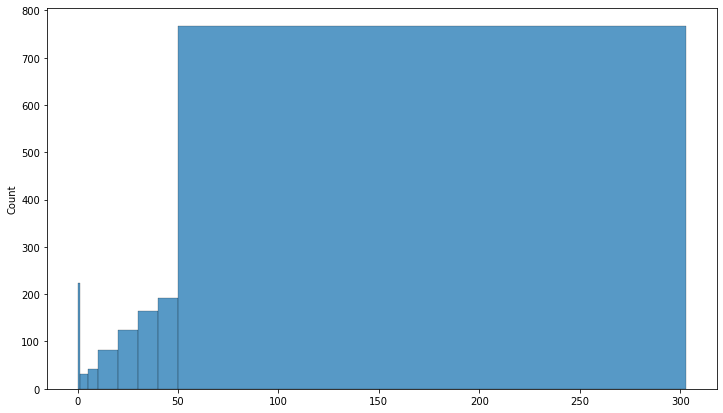

	##################################### T3 #####################################


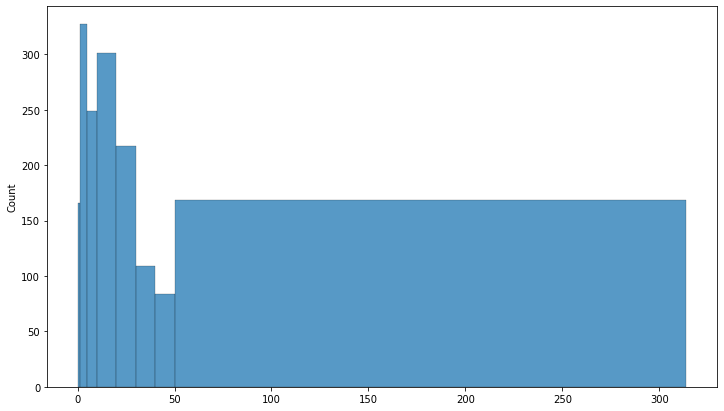

	##################################### T4 #####################################


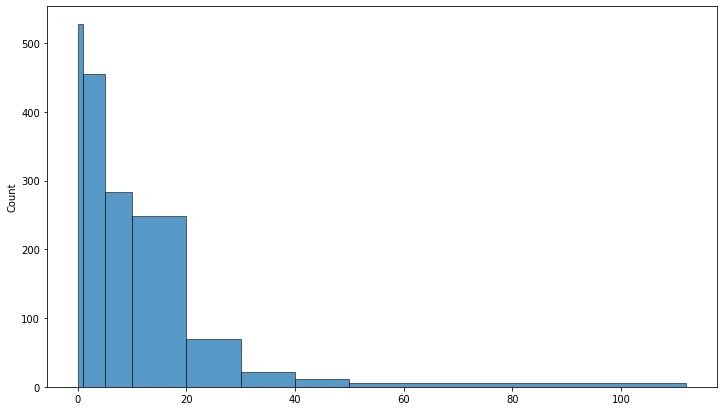

	##################################### T5 #####################################


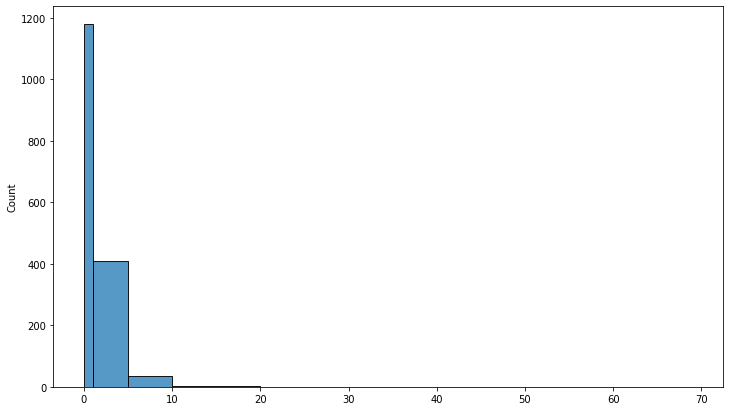

	##################################### T6 #####################################


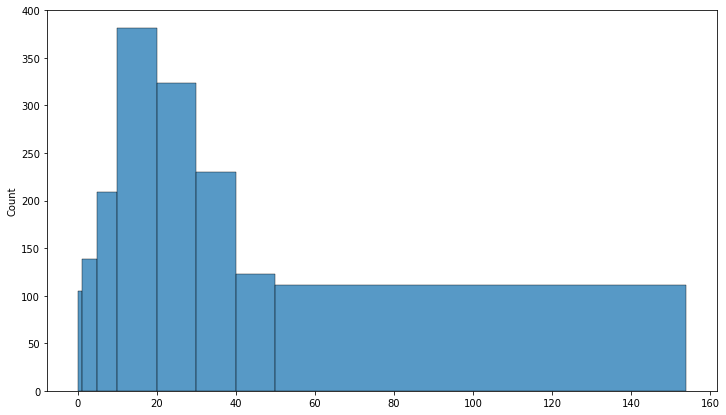

In [ ]:
#plot the histogram
for T_num in range(6):
    plt.figure(figsize=(12,7))
    p_data = fold_1_labels[:, T_num]
    print(f"\t##################################### T{T_num+1} #####################################")
    sns.histplot(x=p_data, bins=[0, 1, 5, 10, 20, 30, 40, 50, max(p_data+[50])])
    #plt.title(f'T{T_num+1}')
    plt.show()

- #### Both T1 and T5 counts seem to be very small or zero from the plots above. 
- #### T4 counts also seem to be low, however not tending to zero as much as T1 and T5.
- #### T2 counts seem to be large in general, with a lot of samples having cell count > 50.
- #### T3 and T6 also have counts that are relatively large, and seem to be distributed well across all the bin ranges

## Converting to HED space
Converting from RGB to Haematoxylin-Eosin-DAB(HED) space, which is better suited to study histology samples. We are specifically interested in the H-channel(Haematoxylin), which is the stain that will highlight the cells we are focussing on.

In [ ]:
from skimage.color import rgb2hed, hed2rgb

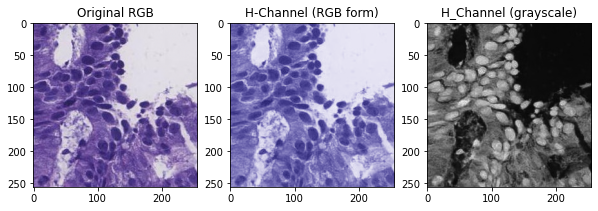

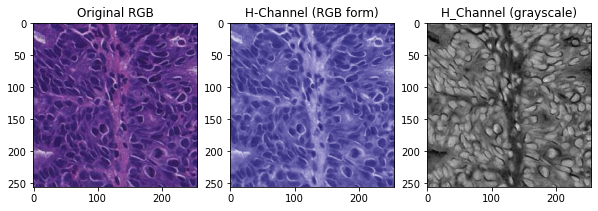

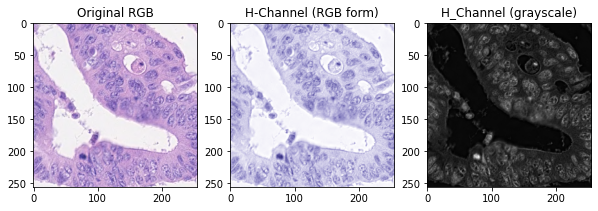

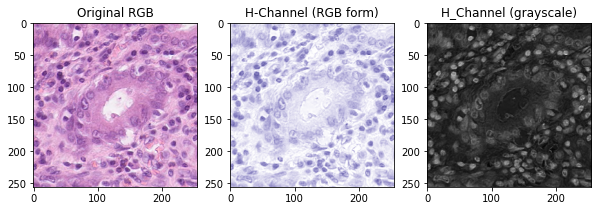

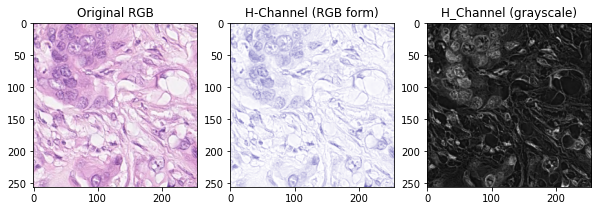

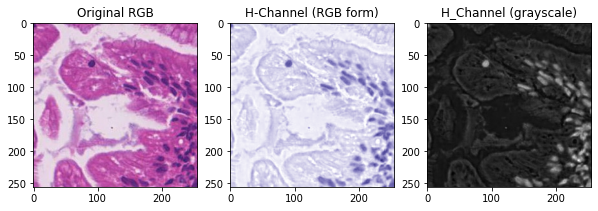

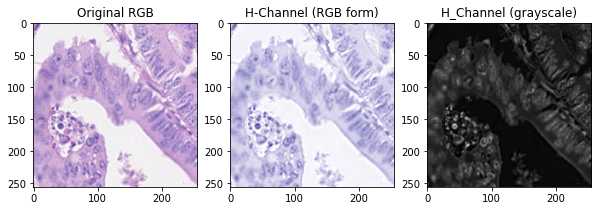

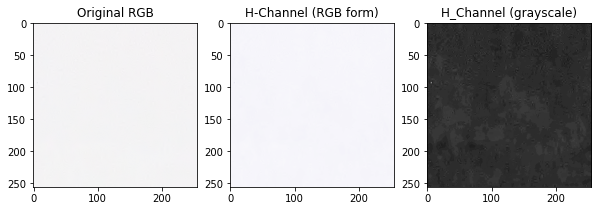

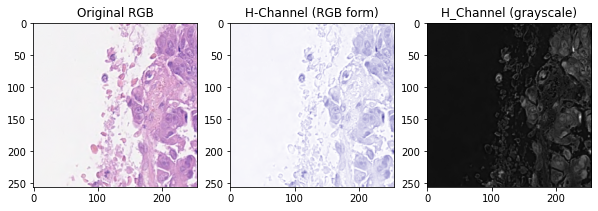

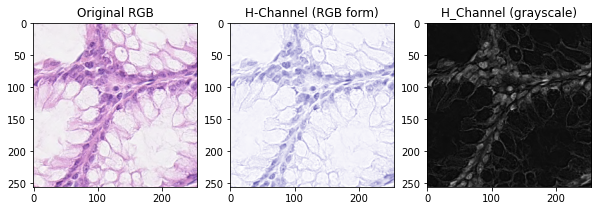

In [ ]:
#Compare original-RGB and H-Channel versions of 10 images
for i in range(10):

    idx = random.randrange(X.shape[0])
    try_img = X[idx]/255.0
    hed = rgb2hed(try_img)
    hed.shape

    # Create an RGB image for each of the stains
    filler = np.zeros_like(hed[:, :, 0])
    H = hed2rgb(np.stack((hed[:, :, 0], filler, filler), axis=-1))
    E = hed2rgb(np.stack((filler, hed[:, :, 1], filler), axis=-1))
    D = hed2rgb(np.stack((filler, filler, hed[:, :, 2]), axis=-1))
    
    just_hed = hed[:, :, 0]

    fig, axes = plt.subplots(1, 3, figsize=(10,10))

    axes[0].imshow(try_img)
    axes[0].title.set_text('Original RGB')

    axes[1].imshow(H)
    axes[1].title.set_text('H-Channel (RGB form)')
    
    axes[2].imshow(just_hed, cmap='gray')
    axes[2].title.set_text('H_Channel (grayscale)')
    plt.show()

#### The cellular nuclei do actually stand out more in the grayscale H channel image. The contrast with the background is bumped up, and this could be of help to models.

## Average H-Channel vs Cell Count (Scatter Plot)

In [ ]:
#group images and corresponding counts belonging to fold 1
fold = 1

X_fold = [X[i] for i in range(X.shape[0]) if F[i] == fold]
X_fold = np.array(X_fold, dtype=np.uint8)

Y_fold = [Y.iloc[i] for i in range(X.shape[0]) if F[i] ==  fold]
Y_fold = np.array(Y_fold, dtype=np.uint8)

In [ ]:
#trying with single channel H-Channel

H_avg_list = []
cell_count_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for i in range(fold_1_imgs.shape[0]):
    img = fold_1_imgs[i]/255.0
    hed = rgb2hed(img)
    hed.shape

    # Create an RGB image for each of the stains
    filler = np.zeros_like(hed[:, :, 0])
    #H = hed2rgb(np.stack((hed[:, :, 0], filler, filler), axis=-1))
    H = hed[:, :, 0]
    
    H_avg = np.average(H)
    cell_counts = fold_1_labels[i]
    
    H_avg_list.append(H_avg)
    
    for j in range(6):
        cell_count_dict[j+1].append(cell_counts[j])

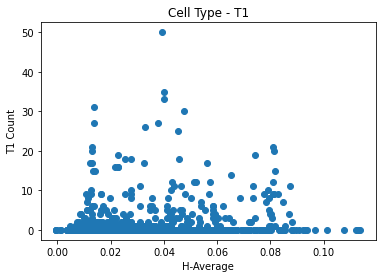

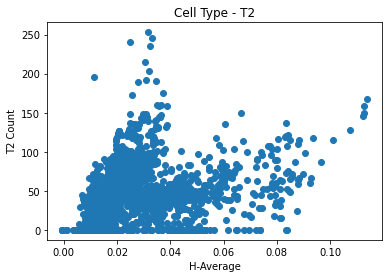

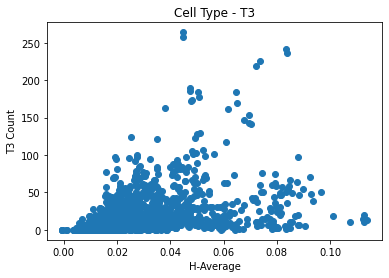

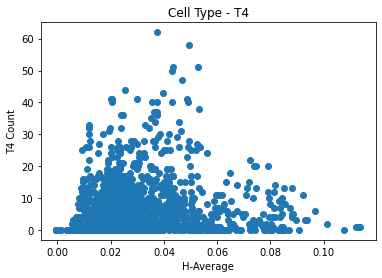

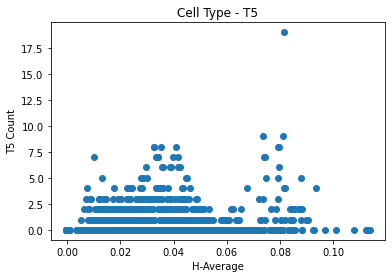

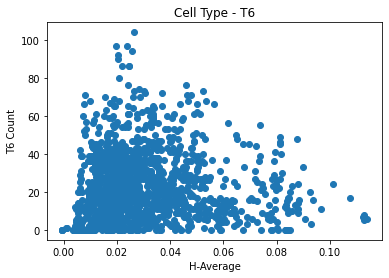

In [ ]:
for cell_type in range(1,7):
    x_vals = np.array(H_avg_list)
    y_vals = np.array(cell_count_dict[cell_type])
    
    plt.scatter(x_vals, y_vals)
    plt.xlabel('H-Average')
    plt.ylabel(f'T{cell_type} Count')
    plt.title(f'Cell Type - T{cell_type}')
    plt.show()

### Would this feature be useful for the regression model?

From the plots above, it appears as though this feature provides valuable information for some cell types and not so much for others.

For example, in the plot for **T3**, it appears as though between H-avg values of `0.04` and `0.08` there is an increased probability of higher **T3 Cell Count**. Similarly, for both very low and high values of H-avg, it seems the cell count is quite low. This seems similar to a bell curve in some ways. The feature could help the model identify cases where T3 counts are quite high and quite low, though it might not add much information for the counts in between.

Similarly, looking at the plot for **T2**, for H-avg values between `0.02` and `0.03` there seems to be a good chance of **T2 Cell count** being large. Post the `0.04` mark, it looks like there is a good positive correlation between the H-avg value and the T2 cell count, as both seem to be increasing in tandem.

For **T1** the general trend seems to be that cell counts are quite low and often zero. There does not seem to be any other clearly discernible trend.

Coming to **T4**, it appears as though there is generally a **negative slope** for the points that have been plotted. This suggests that as H-avg values increase, the T4 cell count is likely to drop lower.

Regarding **T5**, again there does not appear to be any clear patterns. However, looking at the range of values on the y-axis, it is clear generally speaking the **T5** cell counts are quite low.

For **T6**, there seems to be a **negative slope** to the plotted points similar to that observed in the **T4 plot**. Again, this suggests that as H-avg values increase, the cell count is likely to decrease.

Thus, it seems like the H-avg value provides helpful information with respect to some of the cell types and would be a useful feature to supply to different models.

## Which evaluation metric to go for?
There are a variety of evaluation metrics for regression analysis, such as
- MAE (mean absolute error)
- RMSE (root mean squared error)
- R2 Score
- Pearson Correlation Coefficient (PCC)
- Spearman Correlation Coefficient (SCC)

**PCC** and **SCC**, as the names suggest, evaluate the correlation between two distributions/sets of values. In this case, it is a measure of how well the model's predictions correlate with the actual labels. A high correlation score would suggest the model's approximation of the distribution is close to the actual one - which is good.

The **R2 score** is handy because it provides a somewhat standard evaluation metric, in that the error score computed isn't affected by the domain or the scale of values the metric is dealing with. It compares how well the **line fit by the model** compares to the arbitrary **mean line** for the data points. This ratio is invariant to scale of data point values and is thus very useful.

**MAE** is simply the average of the absolute differences between predictions and ground truths. Simple and effective. It punishes all degrees of error equally (linearly).

For this task, I believe **RMSE** would be an intuitive metric to use as it measures the difference in values predicted by the model and the labels (just like MAE). However, because it squares this error, small errors are not punished harshly whereas large errors will be punished considerably. The root of the error ensures that the error value obtained in the end is actually intuitive - for example an RMSE of 10 suggests that on average the model missed the target value by a margin of +/-10. Considering how difficult it is for a human to accurately count the cells in these images, this metric would effectively show how good the ML models are at doing this.

**NOTE:** Something to keep in mind is that RMSE will undoubtedly have different value ranges for the different cell types. That is, for a cell type with larger counts, the RMSE is likely to be larger than the RMSE for a cell type with generally low counts. This is worth taking into account when considering model's performance for each cell type.

# Feature Extraction
Different features are extracted from the image to analyse which ones can add value to a predictor. The images being analysed are from the set in **Fold-1**. The analysis is done by treating count of **T3 Cells** as the target variable, which is the cell type of major interest.

## Extracting average of H, Red, Green and Blue channels
For each image, the average of the HRGB channels are computed and plotted against the **T3** cell type, to check for a correlation.

In [ ]:
#load Fold-1 data
fold_1_idx = (F==1)
fold_1_imgs = X[fold_1_idx]
fold_1_labels = np.array(Y[fold_1_idx])

print('Fold_1_imgs shape: ', fold_1_imgs.shape)
print('Fold_1_labels shape: ', fold_1_labels.shape)

Fold_1_imgs shape:  (1622, 256, 256, 3)
Fold_1_labels shape:  (1622, 6)


In [ ]:
avg_dict = {'H': [], 'R': [], 'G': [], 'B':[]}
#cell_count_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
T3_count_list = []
for i in range(fold_1_imgs.shape[0]):
    img = fold_1_imgs[i]/255.0
    
    #Extract RGB channels
    R = img[0]
    G = img[1]
    B = img[2]
    
    #Extract the H channel
    hed = rgb2hed(img)
    hed.shape
    H = hed[:, :, 0]
    
    #compute the averages
    H_avg = np.average(H)
    R_avg = np.average(R)
    G_avg = np.average(G)
    B_avg = np.average(B)
    
    cell_counts = fold_1_labels[i]
    
    avg_dict['H'].append(H_avg)
    avg_dict['R'].append(R_avg)
    avg_dict['G'].append(G_avg)
    avg_dict['B'].append(B_avg)
    
    T3_count_list.append(cell_counts[2])

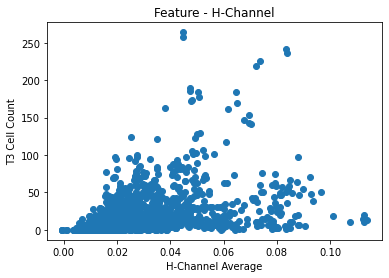

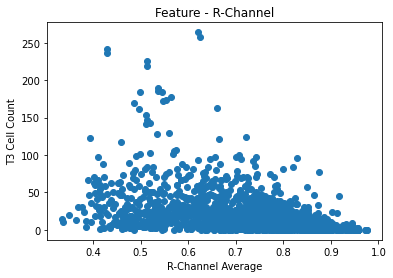

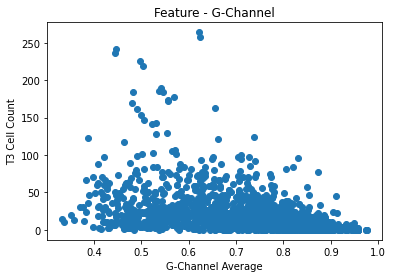

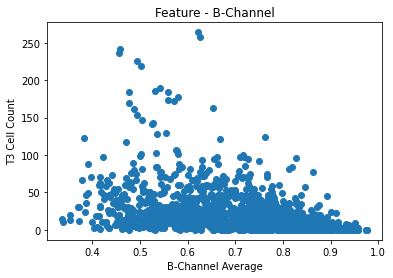

In [ ]:
for feature in avg_dict.keys():
    x_vals = np.array(avg_dict[feature])
    y_vals = np.array(T3_count_list)
    
    plt.scatter(x_vals, y_vals)
    plt.xlabel(f'{feature}-Channel Average')
    plt.ylabel('T3 Cell Count')
    plt.title(f'Feature - {feature}-Channel')
    plt.show()

## Extracting variance of H, Red, Green and Blue channels
For each image, the variance of the HRGB channels are computed and plotted against the **T3** cell type, to check for a correlation.

In [ ]:
variance_dict = {'H': [], 'R': [], 'G': [], 'B':[]}
#cell_count_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
T3_count_list = []
for i in range(fold_1_imgs.shape[0]):
    img = fold_1_imgs[i]/255.0
    #Extract RGB channels
    R = img[0]
    G = img[1]
    B = img[2]
    
    #Extract the H channel
    hed = rgb2hed(img)
    hed.shape
    H = hed[:, :, 0]
    
    #compute the averages
    H_var = np.var(H)
    R_var = np.var(R)
    G_var = np.var(G)
    B_var = np.var(B)
    
    cell_counts = Y_fold[i]
    
    variance_dict['H'].append(H_var)
    variance_dict['R'].append(R_var)
    variance_dict['G'].append(G_var)
    variance_dict['B'].append(B_var)
    
    #store the corresponding T3 cell counts
    T3_count_list.append(cell_counts[2])

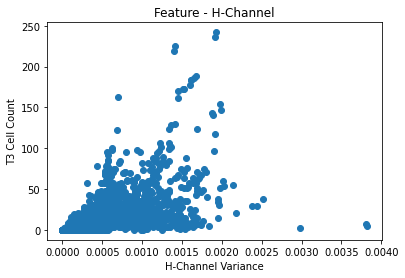

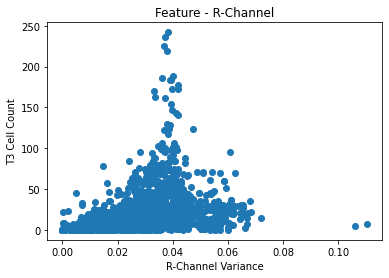

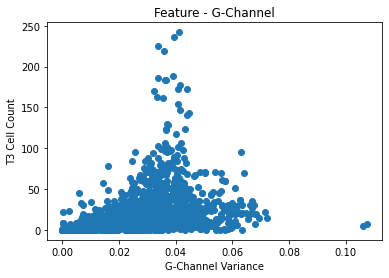

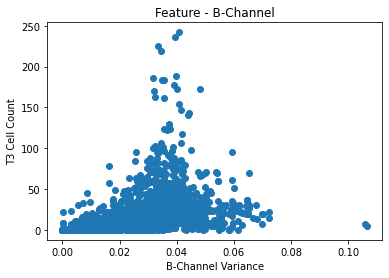

In [ ]:
for feature in variance_dict.keys():
    x_vals = np.array(variance_dict[feature])
    y_vals = np.array(T3_count_list)
    
    plt.scatter(x_vals, y_vals)
    plt.xlabel(f'{feature}-Channel Variance')
    plt.ylabel('T3 Cell Count')
    plt.title(f'Feature - {feature}-Channel')
    plt.show()

## Extracting entropy of H, Red, Green and Blue channels
For each image, the entropy of the HRGB channels are computed and plotted against the **T3** cell type, to check for a correlation.

In [ ]:
import skimage.measure 

In [ ]:
#with pixel intensity normalization
entropy_dict = {'H': [], 'R': [], 'G': [], 'B':[]}
#cell_count_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
T3_count_list = []
for i in range(fold_1_imgs.shape[0]):
    img = fold_1_imgs[i]/255.0
    #Extract RGB channels
    R = img[0]
    G = img[1]
    B = img[2]
    
    #Extract the H channel
    hed = rgb2hed(img)
    hed.shape
    H = hed[:, :, 0]
    
    #compute the averages
    H_ent = skimage.measure.shannon_entropy(H)
    R_ent = skimage.measure.shannon_entropy(R)
    G_ent = skimage.measure.shannon_entropy(G)
    B_ent = skimage.measure.shannon_entropy(B)
    
    cell_counts = Y_fold[i]
    
    entropy_dict['H'].append(H_ent)
    entropy_dict['R'].append(R_ent)
    entropy_dict['G'].append(G_ent)
    entropy_dict['B'].append(B_ent)
    
    #store the corresponding T3 cell counts
    T3_count_list.append(cell_counts[2])

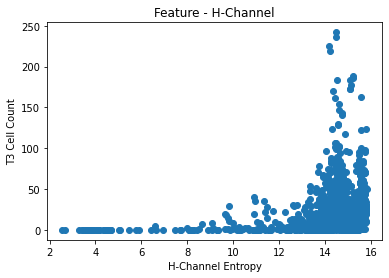

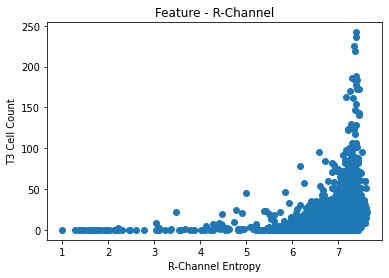

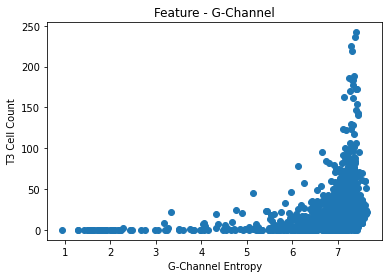

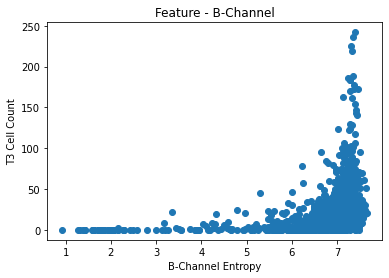

In [ ]:
for feature in entropy_dict.keys():
    x_vals = np.array(entropy_dict[feature])
    y_vals = np.array(T3_count_list)
    
    plt.scatter(x_vals, y_vals)
    plt.xlabel(f'{feature}-Channel Entropy')
    plt.ylabel('T3 Cell Count')
    plt.title(f'Feature - {feature}-Channel')
    plt.show()

### Analysis of the Scatter Plots
- It appears that the RGB scatter plots have a quite similar distribution for all the features that were analysed above. This suggests that the three channels may contain **redundant** information and maybe only one needs to be kept.
- H-channel plots appear to be different from the RGB plots for both `average` and `variance`. When it comes to entropy, it looks like all of HRGB have a similar distribution in the scatter plots.
- `Average`: The RGB plots for this metric seem to have a negative correlation with the T3 cell count. As the RGB values increase, it seems like cell count is decreasing. The H-channel in this case seems to have a 'pyramid' shape. Cell count is low at both very high and low values of H.
- `Variance`: Again, there is a lot of similarity between the RGB plots. At around value **0.04**, it seems as though cell count peaks. The H channel doesn't seem to have any discernible pattern as such.
- `Entropy`: There seems to be a very strong signal from the entropy feature for T3 cell count. Beyond a certain threshold for entropy, the cell count spikes in all HRGB channels. This could be a very useful feature to feed to the models.

Thus, to some extent variance, average and entropy (especially) seem to have signals for the data. The overlap between the RGB plots suggests that any one of them (or maybe a single channel averaging the three of them) could be sufficient to hold all the required information.

# Other Features
Trying to extract/engineer any other features that may be useful for the resgression task.

## Principal Component Analysis (PCA)

In [ ]:
#load Fold-1 data
fold_1_idx = (F==1)
fold_1_imgs = X[fold_1_idx]
fold_1_labels = np.array(Y[fold_1_idx])

print('Fold_1_imgs shape: ', fold_1_imgs.shape)
print('Fold_1_labels shape: ', fold_1_labels.shape)

Fold_1_imgs shape:  (1622, 256, 256, 3)
Fold_1_labels shape:  (1622, 6)


In [ ]:
#convert images in fold-1 to grayscale
fold1_gray = [cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).flatten() for img in X_folds[0]]

In [ ]:
fold1_gray = np.array(fold1_gray, dtype=np.uint8)
fold1_gray.shape

(1622, 65536)

In [ ]:
#Find PCA basis using greyscaled samples in Fold-1
pca = PCA()

pca.fit(fold1_gray)

PCA()

In [ ]:
#view how much each PC contributes to explaining the variance in the dataset
pca.explained_variance_ratio_

array([4.93991140e-01, 1.94576645e-02, 1.59185618e-02, ...,
       4.10527301e-08, 2.43134886e-08, 6.08637371e-33])

In [ ]:
#round off to 2 decimal places
np.around(pca.explained_variance_ratio_, 3)

array([0.494, 0.019, 0.016, ..., 0.   , 0.   , 0.   ])

#### From the analysis above, it is clear that the top component helps explain only about `50%` of the variance in the dataset. Thus, this compnent alone will probably not help the model much. Next, scree graph analysis is done to choose a suitable number of PC's as fearures.

In [ ]:
#cumulatively adding variances to use for displaying scree graph

individual_variances = pca.explained_variance_ratio_
cumulative_variances = [0]*len(individual_variances)
cumulative_variances[0] = individual_variances[0]

for i in range(1,len(individual_variances)):
    cumulative_variances[i] = individual_variances[i] + cumulative_variances[i-1]
cumulative_variances

[0.4939911399504808,
 0.5134488044485818,
 0.52936736626785,
 0.5395968781858997,
 0.5488850346338556,
 0.5566236184595824,
 0.5637935335267877,
 0.5705783404186947,
 0.5766321576095869,
 0.582232960722663,
 0.5870065936853586,
 0.5915738609606602,
 0.5958113987492477,
 0.5998154945096674,
 0.6036618969195312,
 0.6072717804315667,
 0.6107816097770599,
 0.6141439009738102,
 0.617236005188646,
 0.6202517903255147,
 0.6231100242188625,
 0.6258881523927903,
 0.6286285184368163,
 0.6312730681449243,
 0.6338508054558594,
 0.6361776410362998,
 0.6384568816613091,
 0.6406766071814037,
 0.6428612304379526,
 0.644991621078124,
 0.6469746356921577,
 0.6489012084203215,
 0.650808400199292,
 0.6526135646254098,
 0.6543975752572145,
 0.656103997149226,
 0.6578015519765119,
 0.6594800894643886,
 0.661122462418902,
 0.6627078365973083,
 0.6642784084594211,
 0.6658194065005745,
 0.6673490826456211,
 0.6688446753100935,
 0.6703009734753832,
 0.671724199156592,
 0.6731179082683376,
 0.674482073982891,
 0

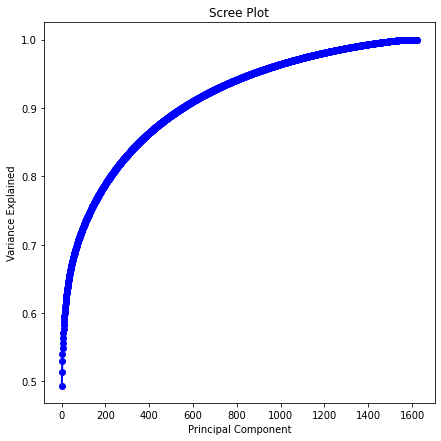

In [ ]:
#plot the scree graph
plt.figure(figsize=(7,7))

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, cumulative_variances, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### From the scree graph, we can see that about 1000 of the top PC's are required to explain 95% of the variance in the dataset. This is still a good reduction in the feature space from the original `256x256 = 65536` features of the original grayscale image

## Gray Level Co-occurence Matrix (GLCM)
Apply GLCM to the whole image to extract some summarised infomration. The features provided by GLCM are:
- contrast
- dissimilarity
- homogeneity
- ASM
- energy
- correlation

These 6 features (for every image) can be passed to the models.

In [ ]:
# open the image
image = X[0]
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


glcm = greycomatrix(image, distances=[5], angles=[0], levels=256,
                    symmetric=True, normed=True)
glcm.shape

#fetch dissimilarity feature to display
greycoprops(glcm, 'dissimilarity')[0, 0]

32.520682893426326

In [ ]:
glcm.shape

(256, 256, 1, 1)

## Helper Function to extract HRGB, PCA and GLCM features
The below function will return the extracted features for a fold based on the flags that are passed to it as parameters.

In [ ]:
#helper function to extract the average, variance and entropy of the H,R,G and B channels. Also extracts GLCM and PCA features if requested.
def extract_features(data_fold, use_glcm=False, pca_model=None):
    
    #placeholder to keep the extracted features
    features = []
    
    #transform data using PCA basis computed earlier
    if pca_model:
        #convert fold images to grayscale
        fold_gray = [cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).flatten() for img in data_fold]
        #transform and keep top 1000 features (as per analysis done in PCA section earlier)
        fold_pca = pca_model.transform(fold_gray)[: , :1000]

    for i in range(data_fold.shape[0]):
        img = data_fold[i]
        gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
#         print(gray.shape)
#         break
        
        #Extract RGB channels
        R = img[0]
        G = img[1]
        B = img[2]

        #Extract the H channel
        hed = rgb2hed(img)
        H = hed[:, :, 0]
        
        #compute the HRGB features
        H_avg, H_var, H_ent = np.average(H), np.var(H), skimage.measure.shannon_entropy(H)
        R_avg, R_var, R_ent = np.average(R), np.var(R), skimage.measure.shannon_entropy(R)
        G_avg, G_var, G_ent = np.average(G), np.var(G), skimage.measure.shannon_entropy(G)
        B_avg, B_var, B_ent = np.average(B), np.var(B), skimage.measure.shannon_entropy(B)
        
        #compute the GLCM features
        if use_glcm:
            glcm = greycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
            dissimilarity = greycoprops(glcm, 'dissimilarity')[0,0]
            correlation = greycoprops(glcm, 'correlation')[0,0]
            contrast = greycoprops(glcm, 'contrast')[0,0]
            homogeneity = greycoprops(glcm, 'homogeneity')[0,0]
            energy = greycoprops(glcm, 'energy')[0,0]
            ASM = greycoprops(glcm, 'ASM')[0,0]
            glcm_features = [dissimilarity, correlation, contrast, homogeneity, energy, ASM]
        
        
            
        all_features = [H_avg, H_var, H_ent, R_avg, R_var, R_ent, G_avg, G_var, G_ent, B_avg, B_var, B_ent]
        
        #Add GLCM features for current image
        if use_glcm:
            all_features = all_features + glcm_features
            
        #Add PCA features for current image
        if pca_model:
            pca_features = list(fold_pca[i])
            all_features = all_features + pca_features
            
        
        
#         print(all_features)
#         break
        features.append(all_features)
        
    return np.array(features, dtype=np.float16)

#### Loading data from the three folds
Data from the folds will be kept separate so that they can be combined in different ways for cross validation if necessary.

In [ ]:
#load data from all the folds and extract required features

#list to hold input features of samples in each fold - 3 separate arrays will be added to list
#corresponding to the 3 different folds
X_folds = []

#list to hold labels of all samples
Y_folds = []

for fold_num in range(1,4):
    #get indices of samples corresponding to fold
    fold_idx = (F==fold_num)
    
    #get image pixel data
    X_data = np.array(X[fold_idx]/255.0, dtype=np.float16)
    #get counts of T3 Cells
    Y_data = np.array(Y[fold_idx])[:, 2]
    
    X_folds.append(X_data)
    Y_folds.append(Y_data)

#### Loading train and test sets. Here, data from folds 1 & 2 are used to create the train set. Fold-3 will be used for testing purposes.

In [ ]:
#display shape of fold-1
X_folds[0].shape

(1622, 256, 256, 3)

In [ ]:
#display shape of fold-2
Y_folds[0].shape

(1622,)

In [ ]:
f1_features = extract_features(X_folds[0], use_glcm=True)
f2_features = extract_features(X_folds[1], use_glcm=True)

print('Fold-1-features Shape: ', f1_features.shape)
print('Fold-2-features Shape: ', f2_features.shape)

Fold-1-features Shape:  (1622, 18)
Fold-2-features Shape:  (1751, 18)


In [ ]:
#combine data from fold-1 and fold-2
X_train = np.vstack((f1_features, f2_features))
X_train.shape

(3373, 18)

In [ ]:
#get the labels for folds 1 and 2
y1 = Y_folds[0]
y1 = y1.reshape((1, len(y1)))
y2 = Y_folds[1]
y2 = y2.reshape((1, len(y2)))

print('Fold-1-labels Shape: ', y1.shape)
print('Fold-2-labels Shape: ', y2.shape)

Fold-1-labels Shape:  (1, 1622)
Fold-2-labels Shape:  (1, 1751)


In [ ]:
Y_train = np.hstack((y1, y2))[0]
Y_train.shape

(3373,)

In [ ]:
Y_train

array([ 4,  2, 14, ...,  1,  1,  1])

In [ ]:
#load the test data from Fold-3

test_X = extract_features(X_folds[2], use_glcm=True)
test_Y = Y_folds[2]

print('Test_X shape: ', test_X.shape)
print('Test_Y shape: ', test_Y.shape)

Test_X shape:  (1608, 18)
Test_Y shape:  (1608,)


# Traditional Regression Models
Ordinary Least Squares (OLS) Regression, Linear SVR and Kernalized SVR are applied to try and predict the number of **T3** cells in each image. Different input features are fed to the models to see how performance is affected. Fold-1 and Fold-2 will be used to train the models and Fold-3 will be used as the unseen test set.

**NOTE**: Three feature combinations were tried for all three types of models below (9 combinations in total). The feature combinations were:
- HRGB only
- HRGB + GLCM
- HRGB + GLCM + PCA

From the analysis, best scores were achieved by the `HRGB + GLCM` features for all three models. Hence, the results for that configuration are shown below to avoid clutter of displaying 6 extra models in the already huge jupyter notebook.

## OLS Regression
Performing OLS regression with HRGB based features and GLCM features as inputs.

In [ ]:
#Initialise and Fit the OLS Linear Regression model
basic_model = LinearRegression().fit(X_train, Y_train)

In [ ]:
#inference on test samples
test_preds = basic_model.predict(test_X)

In [ ]:
test_preds

array([29.682388 , 28.802956 , 23.618145 , ...,  5.8126316, 18.154732 ,
        8.344578 ], dtype=float32)

In [ ]:
test_Y

array([0, 1, 3, ..., 1, 8, 3])

In [ ]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_Y)))
print('R2 Score: ', r2_score(test_preds, test_Y))
print('PCC: ', pearsonr(test_preds, test_Y)[0])
print('SCC: ', spearmanr(test_preds, test_Y)[0])

RMSE:  23.687025523747877
R2 Score:  -0.23510113617263406
PCC:  0.6194822167017553
SCC:  0.6537661637002273


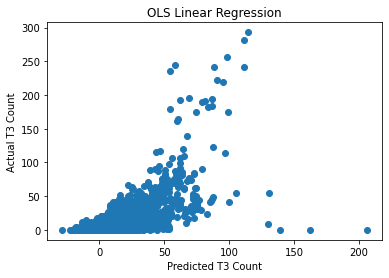

In [ ]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_Y)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('OLS Linear Regression')
plt.show()

#### Looking at the scatter plot for the OLS Linear Regression model, an important observation is that this model seems to be capable of predicting a larger portion of samples with a high T3 cell count. For some reason both the SVR models below do not make predictions higher than approx `80` (as seen from their scatter plots in below cells).

## Linear Support Vector Regression

#### Grid Search - this is done first to determine optimal hyperparameters

In [ ]:
#Grid Search for Hyperparameter optimization

#Xtr, Xv, ytr, yv = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)
hyper_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'max_iter': [10000]}
scoring_metrics = ['neg_root_mean_squared_error', 'r2']

for met in scoring_metrics:
    print(f'Performing Grid Search with {met} as the evaluation metric')
    clf = GridSearchCV(LinearSVR(), hyper_parameters, scoring=met)

    #Use stratified shuffle split to generate a train/val set that maintains class ratio
#     for train_index, val_index in sss.split(X_train, Y_train):
#         Xtr, Xv = X_train_minmax[train_index], X_train_minmax[val_index]
#         ytr, yv = Y_train[train_index], Y_train[val_index]

    #Perform Grid Search    
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set: \n")
    print(clf.best_params_)

    print("Grid scores on development set: \n")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("\n")
    y_true, y_pred = test_Y, clf.predict(test_X)
    print('RMSE on Validation Set: ', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 score on Validation Set: ', r2_score(y_true, y_pred))
    print("########################################################################")

Performing Grid Search with neg_root_mean_squared_error as the evaluation metric


/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/p

Best parameters set found on development set: 

{'C': 100, 'max_iter': 10000}
Grid scores on development set: 

-30.559 (+/-22.003) for {'C': 0.001, 'max_iter': 10000}
-30.258 (+/-21.742) for {'C': 0.01, 'max_iter': 10000}
-29.673 (+/-21.303) for {'C': 0.1, 'max_iter': 10000}
-28.951 (+/-20.881) for {'C': 1, 'max_iter': 10000}
-28.351 (+/-20.496) for {'C': 10, 'max_iter': 10000}
-27.989 (+/-20.334) for {'C': 100, 'max_iter': 10000}
-30.209 (+/-15.573) for {'C': 1000, 'max_iter': 10000}
-29.657 (+/-20.424) for {'C': 10000, 'max_iter': 10000}


RMSE on Validation Set:  27.364909696660142
r2 score on Validation Set:  0.14233583500033387
########################################################################
Performing Grid Search with r2 as the evaluation metric


/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/p

Best parameters set found on development set: 

{'C': 10, 'max_iter': 10000}
Grid scores on development set: 

-0.207 (+/-0.331) for {'C': 0.001, 'max_iter': 10000}
-0.177 (+/-0.295) for {'C': 0.01, 'max_iter': 10000}
-0.124 (+/-0.230) for {'C': 0.1, 'max_iter': 10000}
-0.065 (+/-0.168) for {'C': 1, 'max_iter': 10000}
-0.012 (+/-0.116) for {'C': 10, 'max_iter': 10000}
-0.024 (+/-0.121) for {'C': 100, 'max_iter': 10000}
-0.120 (+/-0.338) for {'C': 1000, 'max_iter': 10000}
-1.864 (+/-7.638) for {'C': 10000, 'max_iter': 10000}


RMSE on Validation Set:  27.54421945396539
r2 score on Validation Set:  0.13105924722487383
########################################################################


/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/jeff/anaconda3/envs/analysis/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### Training using HRGB features and GLCM

In [ ]:
#initialize model with optimal hyperparameters
basic_linear_SVR = LinearSVR(C=100 ,max_iter=10000)

In [ ]:
basic_linear_SVR.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVR(C=100, max_iter=10000)

In [ ]:
test_preds = basic_linear_SVR.predict(test_X)

In [ ]:
test_preds

array([17.81633627, 18.56648281, 16.92762544, ...,  8.82808134,
       18.19041759, 13.34267867])

In [ ]:
test_Y

array([0, 1, 3, ..., 1, 8, 3])

In [ ]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_Y)))
print('R2 Score: ', r2_score(test_preds, test_Y))
print('PCC: ', pearsonr(test_preds, test_Y)[0])
print('SCC: ', spearmanr(test_preds, test_Y)[0])

RMSE:  25.662372933079784
R2 Score:  -6.375611086918692
PCC:  0.5718491296753007
SCC:  0.6510398653221666


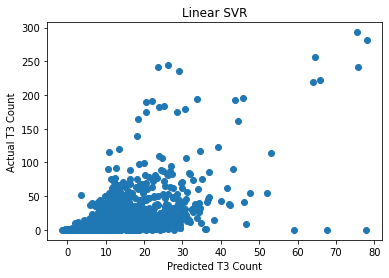

In [ ]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_Y)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('Linear SVR')
plt.show()

## Kernalized Support Vector Regression
#### Grid Search - this is done first to determine optimal hyperparameters

In [ ]:
#Grid Search for Hyperparameter optimization

#Xtr, Xv, ytr, yv = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)
hyper_parameters = {"kernel": ["rbf", "sigmoid"], "gamma": ["scale", "auto"], "cache_size": [1000], "C": [0.001, 0.01, 0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1]}
                   #{"kernel": ["poly"], "degree": [2, 3, 4], "gamma": ["scale", "auto"], "cache_size": [1000], "C": [0.001, 0.01, 0.1, 1, 10, 100], "epsilon": [0.01, 0.1, 0.5, 1.0]}]
scoring_metrics = ['neg_root_mean_squared_error', 'r2']

for met in scoring_metrics:
    print(f'Performing Grid Search with {met} as the evaluation metric')
    clf = GridSearchCV(SVR(), hyper_parameters, scoring=met)

    #Use stratified shuffle split to generate a train/val set that maintains class ratio
#     for train_index, val_index in sss.split(X_train, Y_train):
#         Xtr, Xv = X_train_minmax[train_index], X_train_minmax[val_index]
#         ytr, yv = Y_train[train_index], Y_train[val_index]

    #Perform Grid Search    
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set: \n")
    print(clf.best_params_)

    print("Grid scores on development set: \n")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    print("\n")
    y_true, y_pred = test_Y, clf.predict(test_X)
    print('RMSE on Validation Set: ', np.sqrt(mean_squared_error(y_true, y_pred)))
    print('r2 score on Validation Set: ', r2_score(y_true, y_pred))
    print("########################################################################")

Performing Grid Search with neg_root_mean_squared_error as the evaluation metric
Best parameters set found on development set: 

{'C': 100, 'cache_size': 1000, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Grid scores on development set: 

-31.019 (+/-22.193) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
-31.024 (+/-22.191) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}
-31.010 (+/-22.139) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
-31.024 (+/-22.191) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
-31.022 (+/-22.168) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
-31.028 (+/-22.163) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
-31.009 (+/-22.155) for {'C': 0.001, 'cache_size': 1000, 'epsilon': 0.1, 'gamma': 'auto', 'kerne

RMSE on Validation Set:  26.362204497105484
r2 score on Validation Set:  0.20403737551964996
########################################################################


#### Training using HRGB features and GLCM

In [ ]:
basic_kernel_SVR = SVR(C=100, cache_size=1000, epsilon=0.1, gamma='auto', kernel='rbf')

In [ ]:
basic_kernel_SVR.fit(X_train, Y_train)

SVR(C=100, cache_size=1000, gamma='auto')

In [ ]:
test_preds = basic_kernel_SVR.predict(test_X)

In [ ]:
test_preds

array([22.88580718, 28.41566384, 24.91499158, ...,  7.89745433,
       10.21896585, 25.29854192])

In [ ]:
test_Y

array([0, 1, 3, ..., 1, 8, 3])

In [ ]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_Y)))
print('R2 Score: ', r2_score(test_preds, test_Y))
print('PCC: ', pearsonr(test_preds, test_Y)[0])
print('SCC: ', spearmanr(test_preds, test_Y)[0])

RMSE:  28.716361851153703
R2 Score:  -3.7786233049511715
PCC:  0.2869660460529118
SCC:  0.45001466565741727


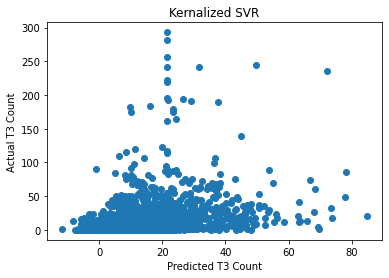

In [ ]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_Y)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('Kernalized SVR')
plt.show()

# Convolutional Neural Networks (CNN)
Use a CNN model to extract feature maps from the images and predict cell counts.

A relatively shallow ResNet architecture was employed for this task - ResNet18. This architecture makes use of `skip connections` which are robust to `vanishing/exploding gradients` (in the shallow 18 layer version maybe this issue is not as pronounced). Architecture also makes use of `Batch Normalisation` which helps with model convergence, provided a decently large batch size is used - in this case batches of 64 are used to train with a GPU.

The ResNet18 model pre-trained on `ImageNet` is loaded using PyTorch to speed up the convergence process.

## CNN to predict the count of T3 cells
Here, fold-3 is used as the test set while using the other two folds to train the CNN model.

In [8]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

from PIL import Image

cudnn.benchmark = True
#plt.ion()   # interactive mode

In [74]:
#load data from all the folds

#list to hold input features of samples in each fold - 3 separate arrays will be added to list
#corresponding to the 3 different folds
X_folds = []

#list to hold labels of all samples
Y_folds = []

for fold_num in range(1,4):
    #get indices of samples corresponding to fold
    fold_idx = (F==fold_num)
    
    #get image pixel data
    X_data = np.array(X[fold_idx], dtype=np.uint8)
    #get counts of T3 Cells
    Y_data = np.array(Y[fold_idx], dtype=np.uint8)[:, 2]
    
    X_folds.append(X_data)
    Y_folds.append(Y_data)

In [75]:
X_folds[0].shape

(1622, 256, 256, 3)

In [76]:
X_folds[1].shape

(1751, 256, 256, 3)

In [ ]:
#combine images from fold-1 and fold-2 to form train set
X_train = np.concatenate((X_folds[0], X_folds[1]), axis=0)
Y_train = np.concatenate((Y_folds[0], Y_folds[1]), axis=0)
print('X-train Shape: ', X_train.shape)
print('Y-train Shape: ', Y_train.shape)

X-train Shape:  (3373, 256, 256, 3)
Y-train Shape:  (3373,)


In [ ]:
#use fold-3 as the unseen test set
X_test = X_folds[2]
Y_test = Y_folds[2]
print('X-test Shape: ', X_test.shape)
print('Y-test Shape: ', Y_test.shape)

X-test Shape:  (1608, 256, 256, 3)
Y-test Shape:  (1608,)


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_list, transform=None, target_transform=None):
        self.img_labels = annotations
        self.img_list = img_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_list[idx]
        #convert to PIL image as that's what PyTorch uses
        image = Image.fromarray(image)
        
        label = self.img_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return np.array(image, dtype=np.float32), np.array(label, dtype=np.float32)

In [ ]:
#split training data into train and val sets
Xtr, Xv, ytr, yv = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)
print('X-train shape: ', Xtr.shape)
print('Y-train shape: ', ytr.shape)
print('X-val shape: ', Xv.shape)
print('Y-val shape: ', yv.shape)

X-train shape:  (3035, 256, 256, 3)
Y-train shape:  (3035,)
X-val shape:  (338, 256, 256, 3)
Y-val shape:  (338,)


In [ ]:
#create objects of custom dataset class defined earlier
train_ds = CustomImageDataset(ytr, Xtr, transform=data_transforms['train'])
val_ds = CustomImageDataset(yv, Xv, transform=data_transforms['val'])
test_ds = CustomImageDataset(Y_test, X_test, transform=data_transforms['val'])

In [ ]:
#create the dataloaders for train and val sets that will be used to feed batches to CNN
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

In [11]:
#train on GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
next(iter(train_dl))

[tensor([[[[-0.1999,  0.4337,  0.9646,  ...,  0.1426,  0.2624,  0.4166],
           [ 0.1254,  0.8276,  1.4440,  ..., -0.0116,  0.0056,  0.1768],
           [ 0.8104,  1.3755,  1.7352,  ..., -0.2513, -0.2684, -0.2171],
           ...,
           [ 0.5364,  0.5707,  0.7248,  ..., -0.7993, -0.5253, -0.0629],
           [ 0.6563,  0.6563,  0.7419,  ..., -0.9363, -0.6623, -0.3027],
           [ 0.7077,  0.6049,  0.6392,  ..., -0.7479, -0.6794, -0.2342]],
 
          [[-1.2129, -0.4951,  0.1176,  ..., -1.3880, -1.2304, -1.0203],
           [-0.8978, -0.0749,  0.6254,  ..., -1.4930, -1.4055, -1.1954],
           [-0.2675,  0.4503,  0.9055,  ..., -1.5630, -1.5280, -1.4580],
           ...,
           [-1.3179, -1.3004, -1.0203,  ..., -1.5455, -1.5805, -1.4055],
           [-1.1954, -1.2304, -1.0378,  ..., -1.6155, -1.6506, -1.5980],
           [-1.1429, -1.2829, -1.1429,  ..., -1.5980, -1.6681, -1.4755]],
 
          [[ 0.1302,  0.7228,  1.2282,  ...,  0.4091,  0.5485,  0.7751],
           [ 

tensor([ 43.,   7.,  27.,   4.,  31.,  72.,  22.,  37.,   0.,   6.,   0.,  35.,
         45., 140.,   0.,   0.,   4.,  90.,  30.,   7.,   1.,  32.,  57.,   0.,
         37.,   2.,  29.,   8.,   0.,   7.,  14.,  17.,   4.,  24.,   4.,   6.,
          8.,   3.,   0.,  39.,   3.,   7.,   0.,   3.,  29.,  17.,  19.,   0.,
          7.,   0.,   0.,   7.,   8.,  31.,  15.,   0.,   1.,   7.,  11.,  14.,
          0.,  16.,  35.,   1.])


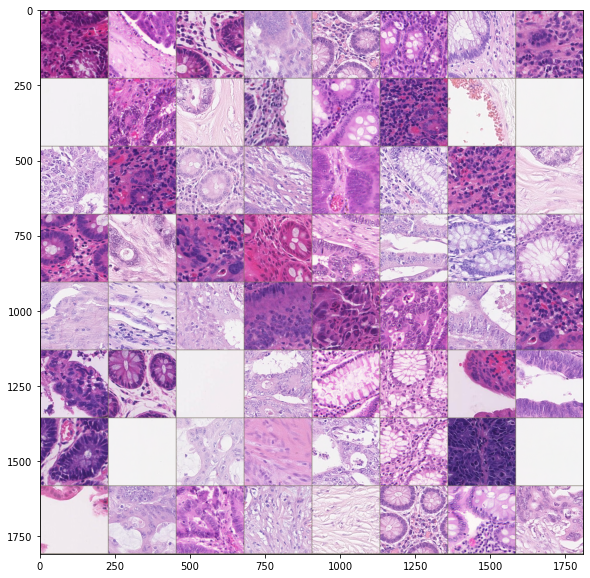

In [ ]:
#display one batch of images and corresponding T3 cell count from the data loader
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dl))

print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(15,10))
imshow(out)

In [ ]:
#bringing all splits in one place for easy access
image_datasets = {'train': train_ds, 'val': val_ds, 'test': test_ds}
dataloaders = {'train': train_dl, 'val': val_dl, 'test': test_dl}
dataset_sizes = {'train': len(ytr), 'val': len(yv), 'test': len(Y_test)}

In [ ]:
dataset_sizes

{'test': 1608, 'train': 3035, 'val': 338}

In [71]:
#loop to train the model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = torch.reshape(outputs, (-1,))
                    # print(outputs.shape)
                    # print(labels.shape)
                    
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                 

                #running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              train_loss_list.append(epoch_loss)
            elif phase == 'val':
              val_loss_list.append(epoch_loss)

            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model (if val loss improved)
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, val_loss_list

In [ ]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)
res_model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### The model architecture above shows that the final linear layer contains 1000 units to predict a score for each of the 1000 classes in the ImageNet dataset. This layer will be modified to have just one neuron to predict the score (cell count) for T3 cells.

In [ ]:
num_ftrs = res_model.fc.in_features

# res_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=1024, bias=True),
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1024, out_features=1, bias=True)
# )

res_model.fc = nn.Linear(num_ftrs, 1)
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 472.2227
val Loss: 548.6633

Epoch 1/19
----------
train Loss: 182.8303
val Loss: 2037.5801

Epoch 2/19
----------
train Loss: 161.7363
val Loss: 359.8889

Epoch 3/19
----------
train Loss: 136.3853
val Loss: 810.1220

Epoch 4/19
----------
train Loss: 123.9024
val Loss: 896.8172

Epoch 5/19
----------
train Loss: 107.9604
val Loss: 562.8380

Epoch 6/19
----------
train Loss: 87.2063
val Loss: 470.8786

Epoch 7/19
----------
train Loss: 69.8471
val Loss: 230.6775

Epoch 8/19
----------
train Loss: 58.6846
val Loss: 321.8741

Epoch 9/19
----------
train Loss: 53.7453
val Loss: 369.9124

Epoch 10/19
----------
train Loss: 46.3568
val Loss: 1020.8326

Epoch 11/19
----------
train Loss: 43.1435
val Loss: 275.3059

Epoch 12/19
----------
train Loss: 42.8355
val Loss: 239.3970

Epoch 13/19
----------
train Loss: 38.2284
val Loss: 538.0300

Epoch 14/19
----------
train Loss: 26.5090
val Loss: 304.0632

Epoch 15/19
----------
train Loss: 37.1938
val Loss: 340.

In [ ]:
train_losses

[472.2226738089195,
 182.83028471945144,
 161.7363178762219,
 136.3853482618756,
 123.90242964039132,
 107.96038187865959,
 87.20627693792152,
 69.8471043217516,
 58.684579127781475,
 53.745262046700844,
 46.35681409945794,
 43.14353494785566,
 42.835510647316546,
 38.228385810914894,
 26.5090286873907,
 37.193831242996545,
 30.34056185324856,
 24.907947335408192,
 34.731879526229434,
 23.47659751917228]

In [ ]:
val_losses

[548.6632989736704,
 2037.580103405834,
 359.8889486549874,
 810.1219551041281,
 896.8171534792206,
 562.8379776632997,
 470.8786151592548,
 230.67753315536228,
 321.8740823960163,
 369.9124063570824,
 1020.8326490052353,
 275.3059042755669,
 239.3969861318374,
 538.0299515583106,
 304.06316944551185,
 340.77866778853377,
 378.0053677982127,
 319.42017427704036,
 234.2962103849332,
 192.43358926942363]

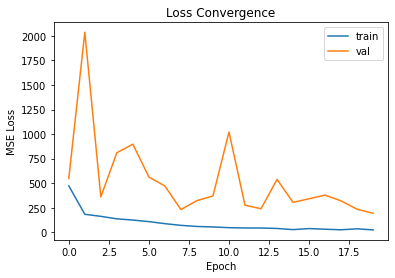

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### Clearly the val loss does fluctuate quite a bit. However, the training loop ensures that the model with the best val loss is stored. Thus, in this case the weights for the model trained at epoch 20 was picked. The convergence plot suggests there is potential for the val loss to go down further, however due to Google Colab time/resource limits, epochs had to be limited.

In [ ]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels = test_labels + list(labels)
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

In [ ]:
test_preds = np.array(test_preds)
test_preds

array([5.1551924, 2.8076906, 4.371533 , ..., 4.3026204, 6.411411 ,
       2.6211991], dtype=float32)

In [ ]:
test_labels = np.array(test_labels)
test_labels

array([0., 1., 3., ..., 1., 8., 3.], dtype=float32)

In [ ]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_labels)))
print('R2 Score: ', r2_score(test_preds, test_labels))
print('PCC: ', pearsonr(test_preds, test_labels)[0])
print('SCC: ', spearmanr(test_preds, test_labels)[0])

RMSE:  12.17405
R2 Score:  0.7462349085126464
PCC:  0.8953713961215773
SCC:  0.8963369623535313


#### The performance across ALL metrics for the ResNet18 model are much better than the classical regression models trained earlier. This highlights the CNN layers are extracting useful features leading to a good predictor. This is a shallow version of ResNet which is still able to perform quite well.

# 3-Fold Cross Validation of ResNet18 (predicting T3 counts)
Three separate models are trained and validated on hold-out sets.


In [77]:
#Helper function to get the dataloaders for the train,val and unseen test sets (based on CV folds passed)
def get_fold_split(train_fold_1, train_labels_1, train_fold_2, train_labels_2, test_fold, test_labels):
  #combine images from train_fold_1 and train_fold_2 to form train set
  X_train = np.concatenate((train_fold_1, train_fold_2), axis=0)
  Y_train = np.concatenate((train_labels_1, train_labels_2), axis=0)

  #split training data into train and val sets
  Xtr, Xv, ytr, yv = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)
  print('X-train shape: ', Xtr.shape)
  print('Y-train shape: ', ytr.shape)
  print()
  print('X-val shape: ', Xv.shape)
  print('Y-val shape: ', yv.shape)
  print()
  print('X-test shape: ', test_fold.shape)
  print('Y-test shape: ', test_labels.shape)

  #create objects of custom dataset class defined earlier
  train_ds = CustomImageDataset(ytr, Xtr, transform=data_transforms['train'])
  val_ds = CustomImageDataset(yv, Xv, transform=data_transforms['val'])
  test_ds = CustomImageDataset(test_labels, test_fold, transform=data_transforms['val'])

  #create the dataloaders for train and val sets that will be used to feed batches to CNN
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16)
  val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16)

  #train on GPU if available, else use CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  #bringing all splits in one place for easy access
  image_datasets = {'train': train_ds, 'val': val_ds, 'test': test_ds}
  dataloaders = {'train': train_dl, 'val': val_dl, 'test': test_dl}
  dataset_sizes = {'train': len(ytr), 'val': len(yv), 'test': len(test_labels)}

  return image_datasets, dataloaders, dataset_sizes

In [78]:
X_fold_1, Y_fold_1 = X_folds[0], Y_folds[0]
X_fold_2, Y_fold_2 = X_folds[1], Y_folds[1]
X_fold_3, Y_fold_3 = X_folds[2], Y_folds[2]

### (Fold-1 & Fold-2 training) with Fold-3 Testing

In [79]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_1, Y_fold_1, X_fold_2, Y_fold_2, X_fold_3, Y_fold_3)

X-train shape:  (3035, 256, 256, 3)
Y-train shape:  (3035,)

X-val shape:  (338, 256, 256, 3)
Y-val shape:  (338,)

X-test shape:  (1608, 256, 256, 3)
Y-test shape:  (1608,)


In [80]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)

#modify final linear layer
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 1)

#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [81]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 403.6646
val Loss: 349.8594

Epoch 1/24
----------
train Loss: 254.3370
val Loss: 725.3827

Epoch 2/24
----------
train Loss: 224.4908
val Loss: 674.3526

Epoch 3/24
----------
train Loss: 199.5333
val Loss: 375.9956

Epoch 4/24
----------
train Loss: 194.2483
val Loss: 704.7685

Epoch 5/24
----------
train Loss: 155.9761
val Loss: 380.6058

Epoch 6/24
----------
train Loss: 125.5397
val Loss: 272.7766

Epoch 7/24
----------
train Loss: 103.3845
val Loss: 292.4788

Epoch 8/24
----------
train Loss: 94.1877
val Loss: 791.0806

Epoch 9/24
----------
train Loss: 77.7159
val Loss: 272.3599

Epoch 10/24
----------
train Loss: 60.9812
val Loss: 190.3297

Epoch 11/24
----------
train Loss: 58.1563
val Loss: 246.4951

Epoch 12/24
----------
train Loss: 55.3473
val Loss: 245.9531

Epoch 13/24
----------
train Loss: 71.7497
val Loss: 300.8430

Epoch 14/24
----------
train Loss: 49.7263
val Loss: 229.5119

Epoch 15/24
----------
train Loss: 36.3922
val Loss: 275.

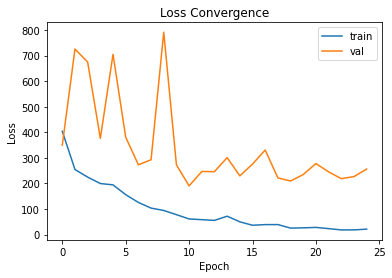

In [82]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [83]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels = test_labels + list(labels)
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [84]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_labels)))
print('R2 Score: ', r2_score(test_preds, test_labels))
print('PCC: ', pearsonr(test_preds, test_labels)[0])
print('SCC: ', spearmanr(test_preds, test_labels)[0])

RMSE:  13.024087
R2 Score:  0.7307093159813105
PCC:  0.880431571516149
SCC:  0.8797820864386412


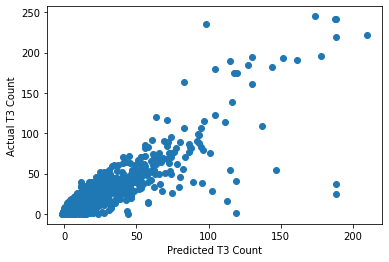

In [85]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_labels)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
#plt.title('Fold 1/2 Train - Fold 3 Test')
plt.show()

In [86]:
#save model to disk
torch.save(res_model.state_dict(), os.path.join(data_dir, 'ResNet18_T3.pth'))

### (Fold-2 & Fold-3 training) with Fold-1 Testing

In [87]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_2, Y_fold_2, X_fold_3, Y_fold_3, X_fold_1, Y_fold_1)

X-train shape:  (3023, 256, 256, 3)
Y-train shape:  (3023,)

X-val shape:  (336, 256, 256, 3)
Y-val shape:  (336,)

X-test shape:  (1622, 256, 256, 3)
Y-test shape:  (1622,)


In [88]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)

#modify final linear layer
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 1)

#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [89]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 390.5204
val Loss: 413.4653

Epoch 1/24
----------
train Loss: 271.5051
val Loss: 604.9622

Epoch 2/24
----------
train Loss: 241.0034
val Loss: 1355.9792

Epoch 3/24
----------
train Loss: 251.0721
val Loss: 526.4790

Epoch 4/24
----------
train Loss: 233.6565
val Loss: 939.9103

Epoch 5/24
----------
train Loss: 189.8572
val Loss: 1225.6637

Epoch 6/24
----------
train Loss: 174.3008
val Loss: 2440.4836

Epoch 7/24
----------
train Loss: 134.7527
val Loss: 543.0858

Epoch 8/24
----------
train Loss: 107.0579
val Loss: 948.9202

Epoch 9/24
----------
train Loss: 85.2370
val Loss: 624.0186

Epoch 10/24
----------
train Loss: 82.2330
val Loss: 422.9522

Epoch 11/24
----------
train Loss: 66.3790
val Loss: 296.2232

Epoch 12/24
----------
train Loss: 66.2738
val Loss: 387.1541

Epoch 13/24
----------
train Loss: 55.8597
val Loss: 334.1804

Epoch 14/24
----------
train Loss: 58.2919
val Loss: 456.0621

Epoch 15/24
----------
train Loss: 61.7970
val Loss: 

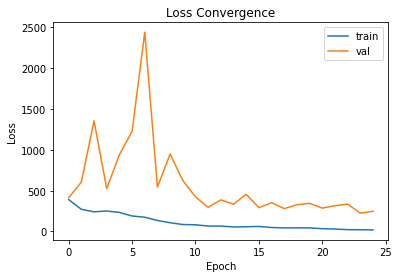

In [90]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [91]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels = test_labels + list(labels)
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [92]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_labels)))
print('R2 Score: ', r2_score(test_preds, test_labels))
print('PCC: ', pearsonr(test_preds, test_labels)[0])
print('SCC: ', spearmanr(test_preds, test_labels)[0])

RMSE:  12.833477
R2 Score:  0.6641796627164409
PCC:  0.8974784717292892
SCC:  0.9194580785744234


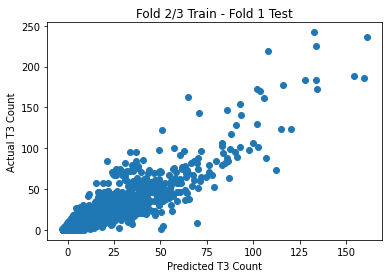

In [93]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_labels)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
plt.title('Fold 2/3 Train - Fold 1 Test')
plt.show()

In [ ]:
#save model to disk
torch.save(res_model.state_dict(), os.path.join(data_dir, 'ResNet18_fold_1_test.pth'))

### (Fold-1 & Fold-3 training) with Fold-2 Testing

In [94]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_1, Y_fold_1, X_fold_3, Y_fold_3, X_fold_2, Y_fold_2)

X-train shape:  (2907, 256, 256, 3)
Y-train shape:  (2907,)

X-val shape:  (323, 256, 256, 3)
Y-val shape:  (323,)

X-test shape:  (1751, 256, 256, 3)
Y-test shape:  (1751,)


In [95]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)

#modify final linear layer
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 1)

#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [96]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 379.9129
val Loss: 290.3257

Epoch 1/24
----------
train Loss: 266.4101
val Loss: 318.6754

Epoch 2/24
----------
train Loss: 217.8066
val Loss: 109.1890

Epoch 3/24
----------
train Loss: 205.0344
val Loss: 85.4693

Epoch 4/24
----------
train Loss: 198.2808
val Loss: 198.5350

Epoch 5/24
----------
train Loss: 178.3093
val Loss: 81.2129

Epoch 6/24
----------
train Loss: 143.3378
val Loss: 129.3026

Epoch 7/24
----------
train Loss: 118.6932
val Loss: 202.5350

Epoch 8/24
----------
train Loss: 96.3333
val Loss: 128.6411

Epoch 9/24
----------
train Loss: 80.4644
val Loss: 108.8953

Epoch 10/24
----------
train Loss: 79.5900
val Loss: 239.8059

Epoch 11/24
----------
train Loss: 72.4113
val Loss: 168.2775

Epoch 12/24
----------
train Loss: 64.0977
val Loss: 245.8039

Epoch 13/24
----------
train Loss: 49.2286
val Loss: 159.9746

Epoch 14/24
----------
train Loss: 49.1389
val Loss: 139.8594

Epoch 15/24
----------
train Loss: 40.5154
val Loss: 120.41

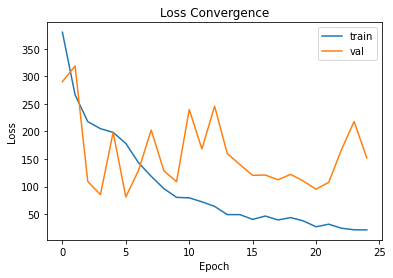

In [97]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [98]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels = test_labels + list(labels)
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [99]:
#get performance metrics
print('RMSE: ', np.sqrt(mean_squared_error(test_preds, test_labels)))
print('R2 Score: ', r2_score(test_preds, test_labels))
print('PCC: ', pearsonr(test_preds, test_labels)[0])
print('SCC: ', spearmanr(test_preds, test_labels)[0])

RMSE:  13.215248
R2 Score:  0.6775835690149268
PCC:  0.8891203132541678
SCC:  0.8900815544907895


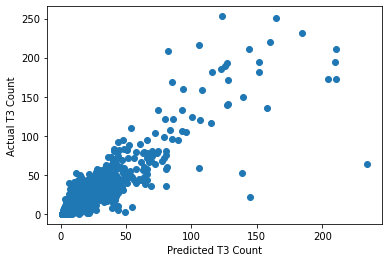

In [100]:
#scatter plot of predicted and actual T3 cell counts
plt.scatter(test_preds, test_labels)
plt.xlabel('Predicted T3 Count')
plt.ylabel('Actual T3 Count')
#plt.title('Fold 2/3 Train - Fold 1 Test')
plt.show()

In [ ]:
#save model to disk
torch.save(res_model.state_dict(), os.path.join(data_dir, 'ResNet18_fold_2_test.pth'))

## Model Performance Comparison on Predicting T3 Cell Count
The table below summarises the performance of the various classical and CNN based regression models that were built.

| Model  | RMSE | R2_Score | PCC | SCC
| --- | --- | --- | --- | --- |
| OLS Regression | 23.69 | -0.24| 0.62 | 0.65
| Linear SVR |  25.66 | -6.38 | 0.57 | 0.65
| Kernalized SVR |  28.72 | -3.78| 0.29 | 0.45
| ResNet18 (Fold-3 Test) | 13.02 | 0.73| 0.88 | 0.88
| ResNet18 (Fold-1 Test) |  12.83 | 0.66 | 0.90 | 0.92
| ResNet18 (Fold-2 Test)| 13.22 | 0.68 | 0.89 | 0.89

From the table it is clear that the CNN based models far outperform the classical approaches for this task.

# 3-Fold Cross Validation to Predict All 6 Cell Types
The idea is to use the same ResNet18 architecture, with the last layer modified to now have 6 units for each of the 6 cell types.

First load the folds again to include all 6 labels, corresponding to the 6 different cell types.

In [12]:
#load data from all the folds

#list to hold input features of samples in each fold - 3 separate arrays will be added to list
#corresponding to the 3 different folds
X_folds = []

#list to hold labels of all samples
Y_folds = []

for fold_num in range(1,4):
    #get indices of samples corresponding to fold
    fold_idx = (F==fold_num)
    
    #get image pixel data
    X_data = np.array(X[fold_idx], dtype=np.uint8)
    #get counts of T3 Cells
    Y_data = np.array(Y[fold_idx], dtype=np.uint8)
    
    X_folds.append(X_data)
    Y_folds.append(Y_data)

In [14]:
X_fold_1, Y_fold_1 = X_folds[0], Y_folds[0]
X_fold_2, Y_fold_2 = X_folds[1], Y_folds[1]
X_fold_3, Y_fold_3 = X_folds[2], Y_folds[2]

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
#loop to train the model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #outputs = torch.reshape(outputs, (-1,))
                    # print(outputs.shape)
                    # print(labels.shape)
                    
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                 

                #running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()
            

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
              train_loss_list.append(epoch_loss)
            elif phase == 'val':
              val_loss_list.append(epoch_loss)

            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model (if val loss improved)
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_list, val_loss_list

In [20]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations, img_list, transform=None, target_transform=None):
        self.img_labels = annotations
        self.img_list = img_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_list[idx]
        #convert to PIL image as that's what PyTorch uses
        image = Image.fromarray(image)
        
        label = self.img_labels[idx]
        #print("Inside Dataset: ", label.shape)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return np.array(image, dtype=np.float32), np.array(label, dtype=np.float32)

In [21]:
#Helper function to get the dataloaders for the train,val and unseen test sets (based on CV folds passed)
def get_fold_split(train_fold_1, train_labels_1, train_fold_2, train_labels_2, test_fold, test_labels):
  #combine images from train_fold_1 and train_fold_2 to form train set
  X_train = np.concatenate((train_fold_1, train_fold_2), axis=0)
  Y_train = np.concatenate((train_labels_1, train_labels_2), axis=0)

  #split training data into train and val sets
  Xtr, Xv, ytr, yv = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)
  print('X-train shape: ', Xtr.shape)
  print('Y-train shape: ', ytr.shape)
  print()
  print('X-val shape: ', Xv.shape)
  print('Y-val shape: ', yv.shape)
  print()
  print('X-test shape: ', test_fold.shape)
  print('Y-test shape: ', test_labels.shape)

  #create objects of custom dataset class defined earlier
  train_ds = CustomImageDataset(ytr, Xtr, transform=data_transforms['train'])
  val_ds = CustomImageDataset(yv, Xv, transform=data_transforms['val'])
  test_ds = CustomImageDataset(test_labels, test_fold, transform=data_transforms['val'])

  #create the dataloaders for train and val sets that will be used to feed batches to CNN
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16)
  val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16)

  #train on GPU if available, else use CPU
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  #bringing all splits in one place for easy access
  image_datasets = {'train': train_ds, 'val': val_ds, 'test': test_ds}
  dataloaders = {'train': train_dl, 'val': val_dl, 'test': test_dl}
  dataset_sizes = {'train': len(ytr), 'val': len(yv), 'test': len(test_labels)}

  return image_datasets, dataloaders, dataset_sizes

In [23]:
#train on GPU if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## (Fold-1 & Fold-2 training) with Fold-3 Testing

In [56]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_1, Y_fold_1, X_fold_2, Y_fold_2, X_fold_3, Y_fold_3)

X-train shape:  (3035, 256, 256, 3)
Y-train shape:  (3035, 6)

X-val shape:  (338, 256, 256, 3)
Y-val shape:  (338, 6)

X-test shape:  (1608, 256, 256, 3)
Y-test shape:  (1608, 6)


In [57]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Modifying the final linear layer to have 6 units that predict cell counts for the 6 different cell types

In [58]:
#modify final linear layer (6 outputs units for each of the 6 cell types)
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 6)
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:
#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [60]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 308.0412
val Loss: 259.3262

Epoch 1/29
----------
train Loss: 139.8607
val Loss: 136.3759

Epoch 2/29
----------
train Loss: 119.4416
val Loss: 112.3482

Epoch 3/29
----------
train Loss: 95.1034
val Loss: 171.5568

Epoch 4/29
----------
train Loss: 78.1780
val Loss: 116.2943

Epoch 5/29
----------
train Loss: 65.2500
val Loss: 138.0627

Epoch 6/29
----------
train Loss: 57.9464
val Loss: 93.1968

Epoch 7/29
----------
train Loss: 57.1513
val Loss: 182.9732

Epoch 8/29
----------
train Loss: 52.1577
val Loss: 126.7404

Epoch 9/29
----------
train Loss: 46.0094
val Loss: 78.1925

Epoch 10/29
----------
train Loss: 38.2500
val Loss: 68.4802

Epoch 11/29
----------
train Loss: 31.6198
val Loss: 70.5242

Epoch 12/29
----------
train Loss: 26.4404
val Loss: 71.7318

Epoch 13/29
----------
train Loss: 24.6953
val Loss: 71.5714

Epoch 14/29
----------
train Loss: 22.3893
val Loss: 74.1577

Epoch 15/29
----------
train Loss: 22.0346
val Loss: 70.0413

Epoch 1

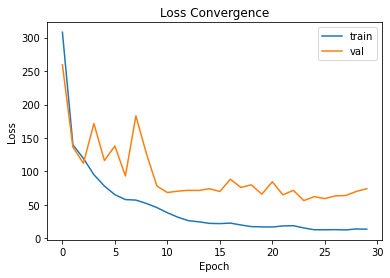

In [61]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [62]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels.extend(list(labels.numpy()))
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        #outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [63]:
#separate out the predictions for each of the 6 cell types
t1_preds, t1_labels = test_preds[:, 0], test_labels[:, 0]
t2_preds, t2_labels = test_preds[:, 1], test_labels[:, 1]
t3_preds, t3_labels = test_preds[:, 2], test_labels[:, 2]
t4_preds, t4_labels = test_preds[:, 3], test_labels[:, 3]
t5_preds, t5_labels = test_preds[:, 4], test_labels[:, 4]
t6_preds, t6_labels = test_preds[:, 5], test_labels[:, 5]

results = [(t1_preds, t1_labels), (t2_preds, t2_labels), (t3_preds, t3_labels), (t4_preds, t4_labels), (t5_preds, t5_labels), (t6_preds, t6_labels)]

### Performance Metrics for All Cell Types

#################### Cell Type - T1 #####################
RMSE:  1.8718154
R2 Score:  -0.9647904501447291
PCC:  0.2140559482230461
SCC:  0.2320164132512248


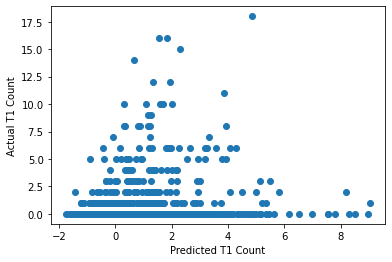

#################### Cell Type - T2 #####################
RMSE:  15.101582
R2 Score:  0.7577892335078458
PCC:  0.8970319060160439
SCC:  0.9142012630339408


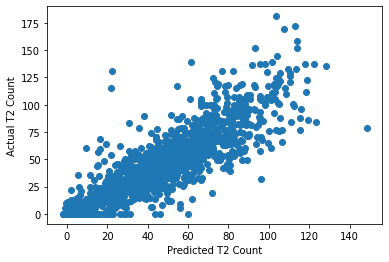

#################### Cell Type - T3 #####################
RMSE:  12.179491
R2 Score:  0.7774879126244496
PCC:  0.8983404867870822
SCC:  0.8901326062989782


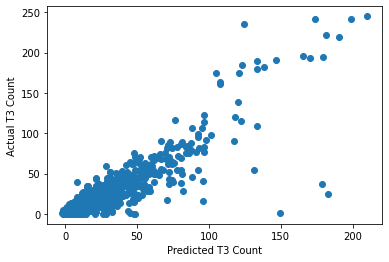

#################### Cell Type - T4 #####################
RMSE:  6.5508876
R2 Score:  0.1580688203735262
PCC:  0.6694571566543924
SCC:  0.7254452243953976


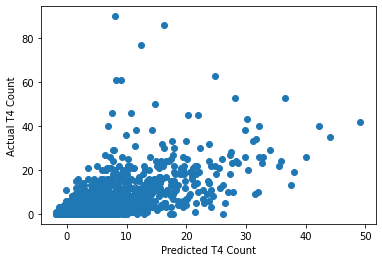

#################### Cell Type - T5 #####################
RMSE:  1.4463004
R2 Score:  -5.045937395051456
PCC:  0.4225339738334884
SCC:  0.44930068219926383


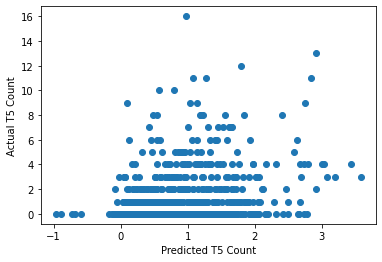

#################### Cell Type - T6 #####################
RMSE:  9.56731
R2 Score:  0.6008403783898507
PCC:  0.8483482555092898
SCC:  0.8193637723277271


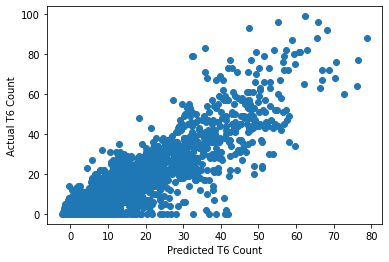

In [64]:
for cell_type in range(6):
  t_preds, t_labels = results[cell_type]
  print(f"#################### Cell Type - T{cell_type+1} #####################")
  
  #display various evaluation metrics
  print('RMSE: ', np.sqrt(mean_squared_error(t_preds, t_labels)))
  print('R2 Score: ', r2_score(t_preds, t_labels))
  print('PCC: ', pearsonr(t_preds, t_labels)[0])
  print('SCC: ', spearmanr(t_preds, t_labels)[0])


  #scatter plot of predicted and actual cell counts
  plt.scatter(t_preds, t_labels)
  plt.xlabel(f'Predicted T{cell_type+1} Count')
  plt.ylabel(f'Actual T{cell_type+1} Count')
  #plt.title(f'Cell Type: T{cell_type+1}')
  plt.show()

## (Fold-2 & Fold-3 training) with Fold-1 Testing

In [40]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_2, Y_fold_2, X_fold_3, Y_fold_3, X_fold_1, Y_fold_1)

X-train shape:  (3023, 256, 256, 3)
Y-train shape:  (3023, 6)

X-val shape:  (336, 256, 256, 3)
Y-val shape:  (336, 6)

X-test shape:  (1622, 256, 256, 3)
Y-test shape:  (1622, 6)


In [41]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)

#modify final linear layer (6 outputs units for each of the 6 cell types)
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 6)

#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [42]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 251.9794
val Loss: 241.7675

Epoch 1/29
----------
train Loss: 139.4208
val Loss: 155.0833

Epoch 2/29
----------
train Loss: 107.9162
val Loss: 149.6525

Epoch 3/29
----------
train Loss: 88.5395
val Loss: 309.6913

Epoch 4/29
----------
train Loss: 74.8008
val Loss: 584.7698

Epoch 5/29
----------
train Loss: 69.0264
val Loss: 558.8791

Epoch 6/29
----------
train Loss: 56.0890
val Loss: 322.7902

Epoch 7/29
----------
train Loss: 46.9503
val Loss: 306.8032

Epoch 8/29
----------
train Loss: 47.5971
val Loss: 140.3614

Epoch 9/29
----------
train Loss: 40.5215
val Loss: 99.0453

Epoch 10/29
----------
train Loss: 34.2882
val Loss: 79.6436

Epoch 11/29
----------
train Loss: 30.2751
val Loss: 117.2219

Epoch 12/29
----------
train Loss: 28.2889
val Loss: 80.9480

Epoch 13/29
----------
train Loss: 25.9993
val Loss: 97.1538

Epoch 14/29
----------
train Loss: 23.1285
val Loss: 86.6327

Epoch 15/29
----------
train Loss: 21.9889
val Loss: 87.5391

Epoch

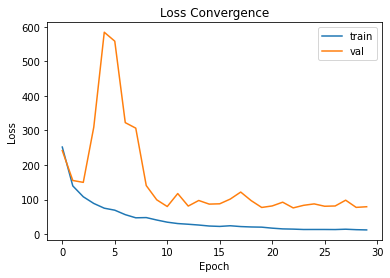

In [43]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [44]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels.extend(list(labels.numpy()))
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        #outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [45]:
#separate out the predictions for each of the 6 cell types
t1_preds, t1_labels = test_preds[:, 0], test_labels[:, 0]
t2_preds, t2_labels = test_preds[:, 1], test_labels[:, 1]
t3_preds, t3_labels = test_preds[:, 2], test_labels[:, 2]
t4_preds, t4_labels = test_preds[:, 3], test_labels[:, 3]
t5_preds, t5_labels = test_preds[:, 4], test_labels[:, 4]
t6_preds, t6_labels = test_preds[:, 5], test_labels[:, 5]

results = [(t1_preds, t1_labels), (t2_preds, t2_labels), (t3_preds, t3_labels), (t4_preds, t4_labels), (t5_preds, t5_labels), (t6_preds, t6_labels)]

### Performance Metrics for All Cell Types

#################### Cell Type - T1 #####################
RMSE:  3.3515375
R2 Score:  -14.741179940307171
PCC:  0.23696974667894713
SCC:  0.25740548427050314


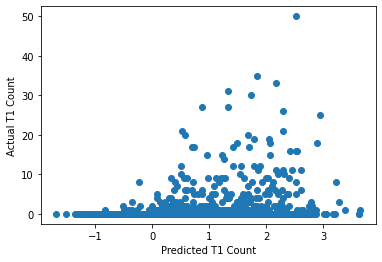

#################### Cell Type - T2 #####################
RMSE:  14.641242
R2 Score:  0.7915444646240533
PCC:  0.9288021026808959
SCC:  0.9320295522765464


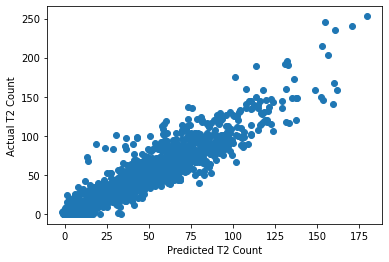

#################### Cell Type - T3 #####################
RMSE:  10.646364
R2 Score:  0.8318029488407807
PCC:  0.9230903175065196
SCC:  0.9222376745884181


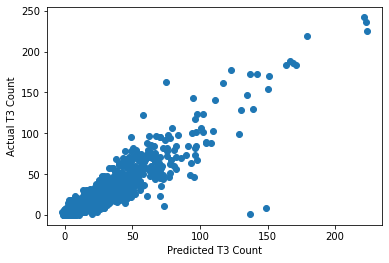

#################### Cell Type - T4 #####################
RMSE:  6.4910674
R2 Score:  -0.5080929689122979
PCC:  0.6204365893387778
SCC:  0.7897882028869674


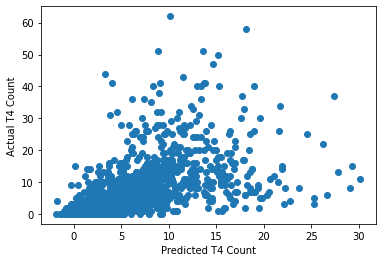

#################### Cell Type - T5 #####################
RMSE:  1.3422633
R2 Score:  -2.0176251565172643
PCC:  0.33928734040378977
SCC:  0.3471292931299492


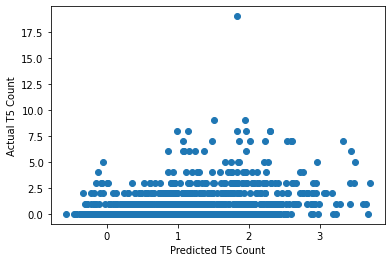

#################### Cell Type - T6 #####################
RMSE:  10.643105
R2 Score:  0.3722057432634003
PCC:  0.7831641519550367
SCC:  0.7808399203232684


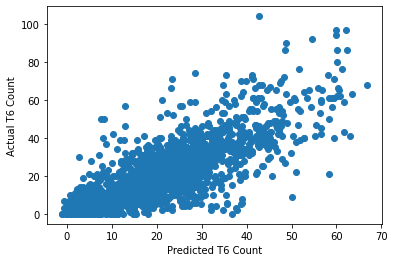

In [47]:
for cell_type in range(6):
  t_preds, t_labels = results[cell_type]
  print(f"#################### Cell Type - T{cell_type+1} #####################")
  
  #display various evaluation metrics
  print('RMSE: ', np.sqrt(mean_squared_error(t_preds, t_labels)))
  print('R2 Score: ', r2_score(t_preds, t_labels))
  print('PCC: ', pearsonr(t_preds, t_labels)[0])
  print('SCC: ', spearmanr(t_preds, t_labels)[0])


  #scatter plot of predicted and actual cell counts
  plt.scatter(t_preds, t_labels)
  plt.xlabel(f'Predicted T{cell_type+1} Count')
  plt.ylabel(f'Actual T{cell_type+1} Count')
  #plt.title(f'Fold-2 Test | Cell Type: T{cell_type+1}')
  plt.show()

## (Fold-1 & Fold-3 training) with Fold-2 Testing

In [49]:
#prepare and get dataloaders for fold split
image_datasets, dataloaders, dataset_sizes = get_fold_split(X_fold_1, Y_fold_1, X_fold_3, Y_fold_3, X_fold_2, Y_fold_2)

X-train shape:  (2907, 256, 256, 3)
Y-train shape:  (2907, 6)

X-val shape:  (323, 256, 256, 3)
Y-val shape:  (323, 6)

X-test shape:  (1751, 256, 256, 3)
Y-test shape:  (1751, 6)


In [50]:
#load ResNet18 model (downloads pre-trained weights if not done so already)
res_model = models.resnet18(pretrained=True)

#modify final linear layer (6 outputs units for each of the 6 cell types)
num_ftrs = res_model.fc.in_features
res_model.fc = nn.Linear(num_ftrs, 6)

#push model to CPU/GPU
res_model = res_model.to(device)

#specify loss function on which parameters will be optimised
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(res_model.parameters(), lr=0.001)

In [51]:
#train the model
res_model, train_losses, val_losses = train_model(res_model, criterion, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 295.3411
val Loss: 173.2131

Epoch 1/29
----------
train Loss: 144.2879
val Loss: 146.3790

Epoch 2/29
----------
train Loss: 112.5858
val Loss: 141.4718

Epoch 3/29
----------
train Loss: 97.2060
val Loss: 123.6760

Epoch 4/29
----------
train Loss: 82.3680
val Loss: 93.3777

Epoch 5/29
----------
train Loss: 70.3408
val Loss: 87.4759

Epoch 6/29
----------
train Loss: 59.3552
val Loss: 61.5684

Epoch 7/29
----------
train Loss: 53.9899
val Loss: 69.1869

Epoch 8/29
----------
train Loss: 59.2519
val Loss: 89.7854

Epoch 9/29
----------
train Loss: 47.9872
val Loss: 118.9381

Epoch 10/29
----------
train Loss: 39.7053
val Loss: 114.6190

Epoch 11/29
----------
train Loss: 35.3274
val Loss: 74.0490

Epoch 12/29
----------
train Loss: 33.0171
val Loss: 75.5625

Epoch 13/29
----------
train Loss: 29.2374
val Loss: 66.5936

Epoch 14/29
----------
train Loss: 27.5489
val Loss: 75.3897

Epoch 15/29
----------
train Loss: 24.7548
val Loss: 55.6753

Epoch 16/

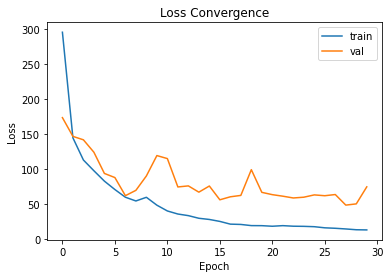

In [52]:
#plot convergence
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [53]:
#run inference on unseen test set

phase = 'test'
res_model.eval()

#list to store predictions from all batches in test set
test_preds = []
test_labels = []

# Iterate over data.
for inputs, labels in dataloaders[phase]:
    inputs = inputs.to(device)
    #labels = labels.to(device)

    test_labels.extend(list(labels.numpy()))
    # zero the parameter gradients
    optimizer.zero_grad()

    #with torch.no_grad():

    with torch.set_grad_enabled(phase == 'train'):
        outputs = res_model(inputs)
        #outputs = torch.reshape(outputs, (-1,))
        outputs = list(outputs.detach().cpu().numpy())
        
        
        #print("################")
        test_preds = test_preds + outputs

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

In [54]:
#separate out the predictions for each of the 6 cell types
t1_preds, t1_labels = test_preds[:, 0], test_labels[:, 0]
t2_preds, t2_labels = test_preds[:, 1], test_labels[:, 1]
t3_preds, t3_labels = test_preds[:, 2], test_labels[:, 2]
t4_preds, t4_labels = test_preds[:, 3], test_labels[:, 3]
t5_preds, t5_labels = test_preds[:, 4], test_labels[:, 4]
t6_preds, t6_labels = test_preds[:, 5], test_labels[:, 5]

results = [(t1_preds, t1_labels), (t2_preds, t2_labels), (t3_preds, t3_labels), (t4_preds, t4_labels), (t5_preds, t5_labels), (t6_preds, t6_labels)]

### Performance Metrics for All Cell Types

#################### Cell Type - T1 #####################
RMSE:  3.2191417
R2 Score:  -5.526452797126428
PCC:  0.2079331238816133
SCC:  0.2875617327647597


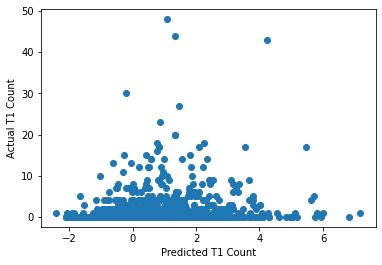

#################### Cell Type - T2 #####################
RMSE:  15.442232
R2 Score:  0.7696897912610534
PCC:  0.8917924437022154
SCC:  0.9204822405693901


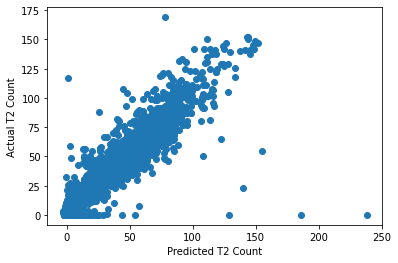

#################### Cell Type - T3 #####################
RMSE:  13.961794
R2 Score:  0.5860976820581205
PCC:  0.883931481160483
SCC:  0.8831105574032752


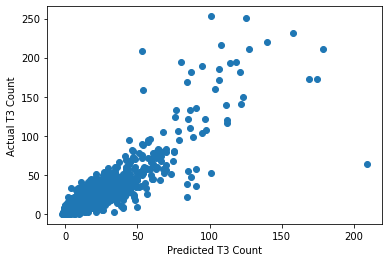

#################### Cell Type - T4 #####################
RMSE:  4.923677
R2 Score:  0.21002686507861112
PCC:  0.7831025923434323
SCC:  0.736600061066663


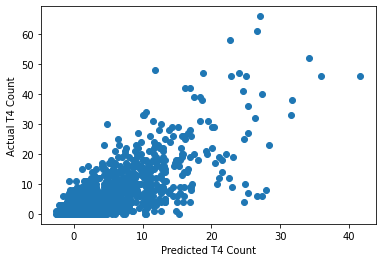

#################### Cell Type - T5 #####################
RMSE:  1.5247264
R2 Score:  -7.2830079780514705
PCC:  0.399494806776627
SCC:  0.45238979352651254


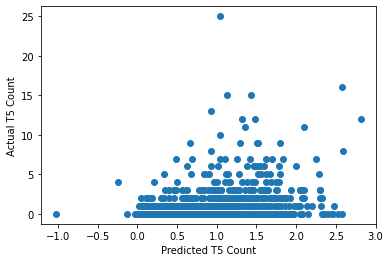

#################### Cell Type - T6 #####################
RMSE:  9.701526
R2 Score:  0.5028807104168832
PCC:  0.8056468000477615
SCC:  0.785411805518421


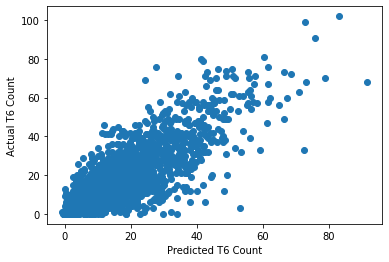

In [55]:
for cell_type in range(6):
  t_preds, t_labels = results[cell_type]
  print(f"#################### Cell Type - T{cell_type+1} #####################")
  
  #display various evaluation metrics
  print('RMSE: ', np.sqrt(mean_squared_error(t_preds, t_labels)))
  print('R2 Score: ', r2_score(t_preds, t_labels))
  print('PCC: ', pearsonr(t_preds, t_labels)[0])
  print('SCC: ', spearmanr(t_preds, t_labels)[0])


  #scatter plot of predicted and actual cell counts
  plt.scatter(t_preds, t_labels)
  plt.xlabel(f'Predicted T{cell_type+1} Count')
  plt.ylabel(f'Actual T{cell_type+1} Count')
  #plt.title(f'Fold-2 Test | Cell Type: T{cell_type+1}')
  plt.show()

# Summary of Results for Each Fold Separately

The table below summarises the performance of the ResNet18 model with regards to predicting **all** of the 6 different cell types by test fold.

### Fold-3 Hold-Out Test Set

| Cell Type  | RMSE | R2_Score | PCC | SCC
| --- | --- | --- | --- | --- |
| T1 | 1.87 | -0.96 | 0.21 | 0.23
| T2 |  15.10 | 0.76 | 0.90 | 0.91
| T3 |  12.18 | 0.78 | 0.90 | 0.89
| T4 | 6.55 | 0.16| 0.67 | 0.73
| T5 |  1.45 | -5.04 | 0.42 | 0.45
| T6 | 9.57 | 0.60 | 0.85 | 0.82

### Fold-1 Hold-Out Test Set

| Cell Type  | RMSE | R2_Score | PCC | SCC
| --- | --- | --- | --- | --- |
| T1 | 3.35 | -14.74 | 0.24 | 0.26
| T2 |  14.64 | 0.79 | 0.93 | 0.93
| T3 |  10.65 | 0.83 | 0.92 | 0.92
| T4 | 6.49 | -0.51| 0.62 | 0.79
| T5 |  1.34 | -2.02 | 0.34 | 0.35
| T6 | 10.64 | 0.37 | 0.78 | 0.78

### Fold-2 Hold-Out Test Set

| Cell Type  | RMSE | R2_Score | PCC | SCC
| --- | --- | --- | --- | --- |
| T1 | 3.22 | -5.53 | 0.21 | 0.29
| T2 |  15.44 | 0.77 | 0.89 | 0.92
| T3 |  13.96 | 0.59 | 0.88 | 0.88
| T4 | 4.92 | 0.21 | 0.78 | 0.74
| T5 |  1.52 | -7.28 | 0.40 | 0.45
| T6 | 9.70 | 0.50 | 0.81 | 0.79

From the tables above, it appears as though **T2 and T3** cell counts are what the model is performing the best on, while also managing decent scores for the **T6** cell type.

# Average Performance across All Folds
The below table highlights the mean scores the model achieved for each cell type across ALL folds. Thus, this summarises the 3-fold cross validation and gives an overall picture of the model's performance.

| Cell Type  | RMSE | R2_Score | PCC | SCC
| --- | --- | --- | --- | --- |
| T1 | 2.81 | -7.08 | 0.22 | 0.26
| T2 |  15.06 | 0.77 | 0.91 | 0.92
| T3 |  12.26 | 0.73 | 0.90 | 0.90
| T4 | 5.99 | -0.05 | 0.69 | 0.75
| T5 |  1.44 | -4.78 | 0.39 | 0.42
| T6 | 9.97 | 0.49 | 0.81 | 0.80

The mean scores verify that the model is performing best on predicting **T2, T3 and T6** cell counts.